In [2]:
# pandas matplotlib numpy networkx graphviz scipy dill configparser coloredlogs mysqlclient requests sarge cryptography paramiko shellescape
from rtt_tools import dump_data
from rtt_tools.dump_data import *  # pussy died because of this wildcard import

import collections
import pickle
import json
import re
import os
import math
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
import random
import itertools
import functools

import networkx as nx
import matplotlib.pyplot as plt
import graphviz
from graphviz import Digraph, Graph
from scipy import stats

import dill
import textwrap
from matplotlib.backends.backend_pdf import PdfPages

logger = logging.getLogger(__name__)
coloredlogs.CHROOT_FILES = []
coloredlogs.install(level=logging.INFO, use_chroot=False)

In [3]:
# path add
ossl_path = os.path.join(os.getenv('HOME'), 'local', 'openssl', 'bin')
if ossl_path not in sys.path: 
    sys.path.append(ossl_path)
    os.environ['PATH'] += ':' + ossl_path

In [4]:
loader = dump_data.Loader()

In [5]:
exp_id_list = [25,26,27] #[10,11,12]  # [2,3,4,5,7,8]

In [ ]:
loader.load({'no_pvals':True, 'only_pval_cnt': True, 'experiments': exp_id_list})  # takes 5 minutes
#loader.load({'no_pvals':False, 'only_pval_cnt': False, 'experiments': exp_id_list})
#loader.load({'no_pvals':False, 'only_pval_cnt': False, 'experiment_ids': list(range(9566, 11570+1))})

In [7]:
# Loader backup to a file, using dill
conn = loader.conn
loader.conn = None

with open('loader-25_26_27.bin', 'wb+') as fh:
    dill.dump(loader, fh)

In [ ]:
loader.conn=conn

In [6]:
# Loading from local file. 1 minute
tload = -time.time()
with open('loader-25_26_27.bin', 'rb+') as fh:
    loader2=dill.load(fh)
    print(loader2, ' time: ', tload+time.time())
    loader.load_from(loader2)

<rtt_tools.dump_data.Loader object at 0x7fb13467e240>  time:  65.78712129592896


In [7]:
# Import booltest results
loader.load_booltest(fname='results_bat_1566891812.json')

In [8]:
#loader.process()
loader.add_passed = True
loader.comp_sub_pvals(add_all=True, pick_one=False)

## Test categorization

In [9]:
# Data sizes -> tests -> test_config -> counts
test_configs = collections.defaultdict(
    lambda: collections.defaultdict(
        lambda: collections.defaultdict(
            lambda: 0
        )))

# Data sizes -> tests -> test_config -> config_data -> counts
test_configs_val = collections.defaultdict(
    lambda: collections.defaultdict(
        lambda: collections.defaultdict(
            lambda: collections.defaultdict(
                lambda: 0
        ))))


# data size -> test_flat -> counts
flat_configs_types = collections.defaultdict(
    lambda: collections.defaultdict(
            lambda: 0
        ))

# data size -> test_flat -> counts
flat_configs = collections.defaultdict(
    lambda: collections.defaultdict(
            lambda: 0
        ))

# Data sizes -> tests -> test_config+variantval -> counts
test_configs_var = collections.defaultdict(
    lambda: collections.defaultdict(
        lambda: collections.defaultdict(
            lambda: 0
        )))


all_subs = []
for tt in loader.tests.values():
    exp = tt.battery.exp
    size = exp.exp_info.size
    tt_id = '|'.join(reversed(tt.short_desc()))

    for vv in tt.variants.values():
        cfs = '|'.join([str(x) for x in vv.settings.keys_tuple()])
        cfv = '|'.join([str(x) for x in vv.settings.values_tuple()])

        for ss in vv.sub_tests.values():
            tfs = '|'.join([str(x) for x in ss.params.keys_tuple()])
            tfv = '|'.join([str(x) for x in ss.params.values_tuple()])
            tcfg = '{%s}{%s}' % (cfs, tfs)
            tcfg_val = '{%s}{%s}' % (cfv, tfv)
            type_val = '[%s][%s]' % (tt_id, tcfg)
            var_val = '{%s}{%s}' % (cfs, cfv) 
            full_val = '[%s][%s][%s]' % (tt_id, tcfg, tcfg_val)

            test_configs[size][tt_id][tcfg] += 1
            test_configs['ALL'][tt_id][tcfg] += 1
            
            test_configs_var[size][tt_id][var_val] += 1
            test_configs_var['ALL'][tt_id][var_val] += 1
            
            test_configs_val[size][tt_id][tcfg][tcfg_val] += 1
            test_configs_val['ALL'][tt_id][tcfg][tcfg_val] += 1
            
            flat_configs[size][full_val] += 1
            flat_configs['ALL'][full_val] += 1
            flat_configs_types[size][type_val] += 1
            flat_configs_types['ALL'][type_val] += 1
            
            if len(ss.pvals) > 0:
                all_subs.append(ss)     

In [10]:
#Broken fragment for pvalues test, SKIP
def logdif(a,b):
    if a == 0 or b == 0: return None
    return math.log(a,2) - math.log(b,2)

def get_pval_partition(pval, pvalbins):
    binidx = 0
    for idx, b in enumerate(pvalbins):
        if pval < b:
            return idx
    return len(pvalbins)

def shortenBat(name):
    name = name.replace('NIST Statistical Testing Suite', 'NSTS')
    name = name.replace('Dieharder', 'D')
    name = name.replace('TestU01 Alphabit', 'U01A')
    name = name.replace('TestU01 Big Crush', 'U01BC')
    name = name.replace('TestU01 Block Alphabit', 'U01BA')
    name = name.replace('TestU01 Rabbit', 'U01R')
    name = name.replace('TestU01 Small Crush', 'U01SC')
    return name

def shortenTest(name, skip_bat=False):
    if isinstance(name, (list, tuple)):
        if skip_bat: name = name[1:]
        name = '|'.join([str(x) for x in name])
    name = shortenBat(name)
    return name

def get_battery_idx(name):
    if isinstance(name, (list,tuple)):
        name = name[0]
    if name.startswith('NIST Statistical Testing Suite'):
        return 0
    elif name.startswith('FIPS140-2'):
        return 1
    elif name.startswith('Dieharder'):
        return 2
    elif name.startswith('TestU01 Alphabit'):
        return 3
    elif name.startswith('TestU01 Big Crush'):
        return 4
    elif name.startswith('TestU01 Block Alphabit'):
        return 5
    elif name.startswith('TestU01 Rabbit'):
        return 6
    elif name.startswith('TestU01 Small Crush'):
        return 7
    elif name.lower().startswith('booltest'):
        return 8
    else:
        return -1

def get_short_bat(idx):
    x = ['NIST', 'FIPS140-2', 'Dieharder', 'U01 Alphabit', 'U01 Big Crush', 'U01 Balphabit', 'U01 Rabbit', 'U01 SCrush', 'Booltest']
    return x[idx] if idx >= 0 else '?' 

In [11]:
print(json.dumps(test_configs_var, indent=2))

{
  "10485760": {
    "Dieharder|Diehard Birthdays Test": {
      "{P-sample count}{65}": 2658
    },
    "Dieharder|Diehard OPERM5 Test": {
      "{P-sample count}{1}": 2658
    },
    "Dieharder|Diehard 32x32 Binary Rank Test": {
      "{P-sample count}{1}": 2658
    },
    "Dieharder|Diehard 6x8 Binary Rank Test": {
      "{P-sample count}{1}": 2658
    },
    "Dieharder|Diehard Bitstream Test": {
      "{P-sample count}{1}": 2658
    },
    "Dieharder|Diehard Count the 1s (stream) Test": {
      "{P-sample count}{39}": 2658
    },
    "Dieharder|Diehard Count the 1s Test (byte)": {
      "{P-sample count}{1}": 2658
    },
    "Dieharder|Diehard Parking Lot Test": {
      "{P-sample count}{100}": 2658
    },
    "Dieharder|Diehard Minimum Distance (2d Circle) Test": {
      "{P-sample count}{100}": 2658
    },
    "Dieharder|Diehard 3d Sphere (Minimum Distance) Test": {
      "{P-sample count}{100}": 2658
    },
    "Dieharder|Diehard Squeeze Test": {
      "{P-sample count}{1}": 26

In [12]:
print(flat_configs.keys())
len(flat_configs[104857600])

dict_keys([10485760, 'ALL', 104857600])


209

In [13]:
lst = sorted(set(list(flat_configs_types['ALL'].keys())))
print(json.dumps(lst, indent=2))

[
  "[Dieharder|DAB DCT][{P-sample count}{}]",
  "[Dieharder|Diehard 32x32 Binary Rank Test][{P-sample count}{}]",
  "[Dieharder|Diehard 3d Sphere (Minimum Distance) Test][{P-sample count}{}]",
  "[Dieharder|Diehard 6x8 Binary Rank Test][{P-sample count}{}]",
  "[Dieharder|Diehard Birthdays Test][{P-sample count}{}]",
  "[Dieharder|Diehard Bitstream Test][{P-sample count}{}]",
  "[Dieharder|Diehard Count the 1s (stream) Test][{P-sample count}{}]",
  "[Dieharder|Diehard Count the 1s Test (byte)][{P-sample count}{}]",
  "[Dieharder|Diehard Craps Test][{P-sample count}{}]",
  "[Dieharder|Diehard Minimum Distance (2d Circle) Test][{P-sample count}{}]",
  "[Dieharder|Diehard OPERM5 Test][{P-sample count}{}]",
  "[Dieharder|Diehard Parking Lot Test][{P-sample count}{}]",
  "[Dieharder|Diehard Runs Test][{P-sample count}{}]",
  "[Dieharder|Diehard Squeeze Test][{P-sample count}{}]",
  "[Dieharder|Marsaglia and Tsang GCD Test][{P-sample count}{}]",
  "[Dieharder|RGB Bit Distribution Test][{N-t

In [14]:
lst = sorted(set(list(flat_configs['ALL'].keys())))
print(len(lst))
print(json.dumps(lst, indent=2))

348
[
  "[Dieharder|DAB DCT][{P-sample count}{}][{1}{}]",
  "[Dieharder|Diehard 32x32 Binary Rank Test][{P-sample count}{}][{19}{}]",
  "[Dieharder|Diehard 32x32 Binary Rank Test][{P-sample count}{}][{1}{}]",
  "[Dieharder|Diehard 3d Sphere (Minimum Distance) Test][{P-sample count}{}][{100}{}]",
  "[Dieharder|Diehard 6x8 Binary Rank Test][{P-sample count}{}][{1}{}]",
  "[Dieharder|Diehard 6x8 Binary Rank Test][{P-sample count}{}][{41}{}]",
  "[Dieharder|Diehard Birthdays Test][{P-sample count}{}][{100}{}]",
  "[Dieharder|Diehard Birthdays Test][{P-sample count}{}][{65}{}]",
  "[Dieharder|Diehard Bitstream Test][{P-sample count}{}][{1}{}]",
  "[Dieharder|Diehard Bitstream Test][{P-sample count}{}][{95}{}]",
  "[Dieharder|Diehard Count the 1s (stream) Test][{P-sample count}{}][{100}{}]",
  "[Dieharder|Diehard Count the 1s (stream) Test][{P-sample count}{}][{39}{}]",
  "[Dieharder|Diehard Count the 1s Test (byte)][{P-sample count}{}][{19}{}]",
  "[Dieharder|Diehard Count the 1s Test (byte

In [15]:
print(json.dumps(flat_configs, indent=2))

{
  "10485760": {
    "[Dieharder|Diehard Birthdays Test][{P-sample count}{}][{65}{}]": 2658,
    "[Dieharder|Diehard OPERM5 Test][{P-sample count}{}][{1}{}]": 2658,
    "[Dieharder|Diehard 32x32 Binary Rank Test][{P-sample count}{}][{1}{}]": 2658,
    "[Dieharder|Diehard 6x8 Binary Rank Test][{P-sample count}{}][{1}{}]": 2658,
    "[Dieharder|Diehard Bitstream Test][{P-sample count}{}][{1}{}]": 2658,
    "[Dieharder|Diehard Count the 1s (stream) Test][{P-sample count}{}][{39}{}]": 2658,
    "[Dieharder|Diehard Count the 1s Test (byte)][{P-sample count}{}][{1}{}]": 2658,
    "[Dieharder|Diehard Parking Lot Test][{P-sample count}{}][{100}{}]": 2658,
    "[Dieharder|Diehard Minimum Distance (2d Circle) Test][{P-sample count}{}][{100}{}]": 2658,
    "[Dieharder|Diehard 3d Sphere (Minimum Distance) Test][{P-sample count}{}][{100}{}]": 2658,
    "[Dieharder|Diehard Squeeze Test][{P-sample count}{}][{1}{}]": 2658,
    "[Dieharder|Diehard Runs Test][{P-sample count}{}][{24}{}]": 5316,
    "[D

In [16]:
stables = set()
for msize in flat_configs_types:
    tests = flat_configs_types[msize]
    for t in tests:
        stables.add(t)
    
for msize in flat_configs_types:
    tests = flat_configs_types[msize]
    for test in tests:
        # other sizes
        for msize_other in [x for x in flat_configs_types if x != msize]:
            if test not in flat_configs_types[msize_other]:
                stables.discard(test)
                #msize = int(msize)
                #msize_other = int(msize_other)
                print('DIf: %10s->%10s: %s' % (msize, msize_other, test))
    #print(msize)
    
print('Stables....')
for xx in stables:
    print('.. %s' % xx)

DIf:        ALL->  10485760: [Dieharder|Marsaglia and Tsang GCD Test][{P-sample count}{}]
DIf:        ALL->  10485760: [Dieharder|DAB DCT][{P-sample count}{}]
DIf:        ALL->  10485760: [TestU01 Small Crush|smarsa_BirthdaySpacings][{Repetitions}{N|d|n|p|r|t}]
DIf:        ALL->  10485760: [TestU01 Small Crush|sknuth_Collision][{Repetitions}{N|Sparse|d|n|r|t}]
DIf:        ALL->  10485760: [TestU01 Small Crush|sknuth_CouponCollector][{Repetitions}{N|d|n|r}]
DIf:        ALL->  10485760: [TestU01 Small Crush|sknuth_MaxOft][{Repetitions}{N|d|n|r|t}]
DIf:        ALL->  10485760: [TestU01 Small Crush|smarsa_MatrixRank][{Repetitions}{L|N|k|n|r|s}]
DIf:        ALL->  10485760: [TestU01 Small Crush|swalk_RandomWalk1][{Repetitions}{L0|L1|N|n|r|s}]
DIf:  104857600->  10485760: [Dieharder|Marsaglia and Tsang GCD Test][{P-sample count}{}]
DIf:  104857600->  10485760: [Dieharder|DAB DCT][{P-sample count}{}]
DIf:  104857600->  10485760: [TestU01 Small Crush|smarsa_BirthdaySpacings][{Repetitions}{N|d|

## Test analysis

In [25]:
# Test analysis and scoring
exps = list(loader.experiments.values())
exps.sort(key=lambda x: (x.exp_info.size, x.exp_info.meth, x.exp_info.seed, x.exp_info.fnc_name, x.exp_info.fnc_round))
exps_grouper = lambda x: (x.exp_info.size, x.exp_info.meth, x.exp_info.fnc_name, x.exp_info.fnc_round)  # aggregate different runs with different SEEDs
rev_exp = {x.name: i for i,x in enumerate(exps)}

# Iterate over test
# test[name] = [pvals] per experiment, on a fixed position. None if not present.
tests = collections.defaultdict(lambda: [None] * len(exps))
tests_map = {}
test_ids_counts = collections.defaultdict(lambda: 0)
for tt in loader.tests.values():
    tt_id = '|'.join(reversed(tt.short_desc()))
    tests_map[tt_id] = tt
    tests[tt_id][rev_exp[tt.battery.exp.name]] =  tt.get_min_pval()  #tt.get_single_pval()  # uses sidak maybe
    # print(tt.get_single_pval(), tt.shidak_alpha(0.10), tt.summarized_pvals)
    
# Sort tests, so we have defined ordering
tests_srt = [(k,tests[k]) for k in tests]
tests_srt.sort(key=lambda x: x[0])

In [13]:
# subtest breakdown
subtests_map = {}
subtests = collections.defaultdict(lambda: [None] * len(exps))
for sti, st in enumerate(loader.sids.values()):
    st_id = tuple(reversed(st.short_desc()))
    subtests_map[st_id] = st
    subtests[st_id][rev_exp[st.variant.test.battery.exp.name]] = st.stats[0].value if st.stats else None
        
# Sort tests, so we have defined ordering
# subtests_srt: List[test_desc_k, [pvals vector, per experiment, fixed experiment positions]]
subtests_srt = [(k,subtests[k]) for k in subtests]
subtests_srt.sort(key=lambda x: x[0]) 

In [14]:
# test + booltest subtest, hybrid access
tests_boolhyb = collections.defaultdict(lambda: [None] * len(exps))
tests_boolhyb_map = {}
for tt in loader.tests.values():
    tt_id = tuple(reversed(tt.short_desc()))
    if 'booltest' in tt_id[0].lower(): continue
    tests_boolhyb_map[tt_id] = tt
    tests_boolhyb[tt_id][rev_exp[tt.battery.exp.name]] = tt.get_min_pval() 
    
for sti, st in enumerate(loader.sids.values()):
    st_id = tuple(reversed(st.short_desc()))
    if 'booltest' not in st_id[0].lower():
        continue
    tests_boolhyb_map[st_id] = st
    tests_boolhyb[st_id][rev_exp[st.variant.test.battery.exp.name]] = st.stats[0].value if st.stats else None
    
# Sort tests, so we have defined ordering
# subtests_srt: List[test_desc_k, [pvals vector, per experiment, fixed experiment positions]]
tests_boolhyb_srt = [(k,tests_boolhyb[k]) for k in tests_boolhyb]
tests_boolhyb_srt.sort(key=lambda x: x[0]) 

In [54]:
tests_bools = collections.defaultdict(lambda: [None] * len(exps))
tests_bools_map = {}

for sti, st in enumerate(loader.sids.values()):
    st_id = tuple(reversed(st.short_desc()))
    if 'booltest' not in st_id[0].lower():
        continue
    tests_bools_map[st_id] = st
    tests_bools[st_id][rev_exp[st.variant.test.battery.exp.name]] = st.stats[0].value if st.stats else None
    
# Sort tests, so we have defined ordering
# subtests_srt: List[test_desc_k, [pvals vector, per experiment, fixed experiment positions]]
tests_bools_srt = [(k,tests_bools[k]) for k in tests_bools]
tests_bools_srt.sort(key=lambda x: x[0]) 

In [44]:
def dump_matrix(tests, selection):
    exps_names = list(itertools.compress([x.name for x in exps], tf_10mib))
    ctests = filterTests(project_tests(tests, selection))
    res = collections.OrderedDict()
    res['exps_names'] = exps_names
    res['matrix'] = [('|'.join([str(xx) for xx in x[0]]), x[1]) for x in ctests]
    print(json.dumps([x[0] for x in res['matrix']], indent=2))
    with open('/tmp/matrix-dump-4syso-10MB.json', 'w+') as fh:
       json.dump(res, fh, indent=2)
    return res

rrr=dump_matrix(tests_boolhyb_srt, tf_10mib)

[
  "Dieharder|DAB DCT",
  "Dieharder|Diehard 32x32 Binary Rank Test",
  "Dieharder|Diehard 3d Sphere (Minimum Distance) Test",
  "Dieharder|Diehard 6x8 Binary Rank Test",
  "Dieharder|Diehard Birthdays Test",
  "Dieharder|Diehard Bitstream Test",
  "Dieharder|Diehard Count the 1s (stream) Test",
  "Dieharder|Diehard Count the 1s Test (byte)",
  "Dieharder|Diehard Craps Test",
  "Dieharder|Diehard Minimum Distance (2d Circle) Test",
  "Dieharder|Diehard OPERM5 Test",
  "Dieharder|Diehard Parking Lot Test",
  "Dieharder|Diehard Runs Test",
  "Dieharder|Diehard Squeeze Test",
  "Dieharder|Marsaglia and Tsang GCD Test",
  "Dieharder|RGB Bit Distribution Test",
  "Dieharder|RGB Generalized Minimum Distance Test",
  "Dieharder|RGB Kolmogorov-Smirnov Test",
  "Dieharder|RGB Lagged Sum Test",
  "Dieharder|RGB Permutations Test",
  "Dieharder|STS Monobit Test",
  "Dieharder|STS Runs Test",
  "Dieharder|STS Serial Test (Generalized)",
  "NIST Statistical Testing Suite|Approximate Entropy Test",

In [ ]:
with open('/tmp/matrix-dump-4syso.json', 'r') as fh:
    jjj=json.load(fh)
    print(set([len([xx for xx in x[1] if xx is not None]) for x in jjj['matrix']]))

In [30]:
print(set([len([xx for xx in x[1] if xx is not None]) for x in project_tests(tests_boolhyb_srt, tf_10mib)]))

NameError: name 'tf_10mib' is not defined

In [31]:
print("Subtest indices -> params")
for x in subtests_srt:
    print(x[0], subtests_map[x[0]].params)

Subtest indices -> params
('Dieharder', 'DAB DCT', 1, 1) {}
('Dieharder', 'Diehard 32x32 Binary Rank Test', 1, 1) {}
('Dieharder', 'Diehard 3d Sphere (Minimum Distance) Test', 1, 1) {}
('Dieharder', 'Diehard 6x8 Binary Rank Test', 1, 1) {}
('Dieharder', 'Diehard Birthdays Test', 1, 1) {}
('Dieharder', 'Diehard Bitstream Test', 1, 1) {}
('Dieharder', 'Diehard Count the 1s (stream) Test', 1, 1) {}
('Dieharder', 'Diehard Count the 1s Test (byte)', 1, 1) {}
('Dieharder', 'Diehard Craps Test', 1, 1) {}
('Dieharder', 'Diehard Craps Test', 1, 2) {}
('Dieharder', 'Diehard Minimum Distance (2d Circle) Test', 1, 1) {}
('Dieharder', 'Diehard OPERM5 Test', 1, 1) {}
('Dieharder', 'Diehard Parking Lot Test', 1, 1) {}
('Dieharder', 'Diehard Runs Test', 1, 1) {}
('Dieharder', 'Diehard Runs Test', 1, 2) {}
('Dieharder', 'Diehard Squeeze Test', 1, 1) {}
('Dieharder', 'Marsaglia and Tsang GCD Test', 1, 1) {}
('Dieharder', 'Marsaglia and Tsang GCD Test', 1, 2) {}
('Dieharder', 'RGB Bit Distribution Test',

In [ ]:
tests_boolhyb_map[subtests_srt[-1][0]].params

In [32]:
list(loader.sids.values())[0]

Subtest(1, {L: 2, N: 1, Sparse: FALSE, n: 10000000, r: 0, s: 32, w: 1}, lenpvals=0, stats=[Unknown 0:1e-300:False], variant=Variant(1, {Bit NB: 10000000, Bit R: 0, Bit S: 32, Bit W: 1, Repetitions: 1}, test=Test(smultin_MultinomialBitsOver, battery=Battery(TestU01 Block Alphabit, exp=Exp(SECMARGINPAPER25_ctr_seed_4464a22651888b31_10MiB__ARIRANG_r03_b32.bin)))))

In [39]:
def get_maximum_detections(selection, tests_srt, do_p):
    ctests = project_tests(tests_srt, selection)
    total_det = sum(selection) * len(tests_srt)
    tests_undefined = collections.defaultdict(lambda: 0)  # tname -> # of NONE in test
    total_def_det = 0

    # Fails removal & report
    for tname, tvals in ctests:
        for idx, tval in enumerate(tvals):
            if tval is None:
                eidx = get_ex_byidx(selection, idx)
                tests_undefined[tname] += 1
                #print('%s : %s' % (tname, exps[eidx].name))
            else:
                total_def_det += 1
    return total_def_det     
    
def get_detections(ctests, alpha=1e-3):
    totals = len(ctests) * len(ctests[0][1])
    test_fails = [sum(1 for y in x[1] if y is None) for x in ctests]  # no data cases
    tests_detections = [(
        x[0], 
        sum(1 for y in x[1] if y is not None and y <= alpha) / (len(x[1]) - test_fails[i]),
        sum(1 for y in x[1] if y is not None and y <= alpha),
        sum(1 for y in x[1] if y is not None and y <= alpha) + 10,
        test_fails[i],
        len(x[1])
        ) for i, x in enumerate(ctests) if (len(x[1]) - test_fails[i]) > 0]
    return tests_detections

def fill_x_data(x_data, y_data, x_data_desired, fill_fnc=lambda x: 0, sorted_add=None):
    """Augments x, y data to precisely match x_data_desired with fill function. x_data has to be sorted"""
    # Remove all not present
    n_x, n_y = [], []
    xdes_set = set(x_data_desired)
    for ix, name in enumerate(x_data):
        if name in xdes_set:
            n_x.append(x_data[ix])
            n_y.append(y_data[ix])

    # Add all missing, now is a subset
    if sorted_add is not None:
        len_cur = len(n_x)
        missing = [(idx, x) for idx, x in enumerate(x_data_desired) if x not in set(n_x)]
        for ridx, (idx, name) in enumerate(missing):
            ridx_off = ridx + len_cur if sorted_add > 0 else ridx
            n_x.insert(ridx_off, name)
            n_y.insert(ridx_off, fill_fnc((ridx_off, name)))

    else:
        off = 0
        for idx, name in enumerate(x_data_desired):
            if idx >= len(n_x) or n_x[idx] != name:
                n_x.insert(idx, name)
                n_y.insert(idx, fill_fnc((idx, name)))

    return n_x, n_y

def wrapHyphened(txt, width=20):
    res = ['']
    parts = txt.split('-')
    for ix, p in enumerate(parts):
        if len(res[-1]) + len(p) > width:
            res.append('')
        res[-1] += p + ('-' if ix < len(parts)-1 else '')
    return res

def doChunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
    
def filterTests(tests_srt, excl_extra=[], ret_idx=False):
    res = []
    excl= [
        'TestU01 Rabbit|smultin_MultinomialBitsOver',
        'NIST Statistical Testing Suite|Random Excursions Test',
        'NIST Statistical Testing Suite|Random Excursions Variant Test',
    ] + excl_extra
    
    take_idx = []
    for idx, x in enumerate(tests_srt):
        tname = x[0]
        if isinstance(tname, (list, tuple)):
            tname = '|'.join([str(y) for y in tname])
        skip = False
        for exx in excl:
            if tname.startswith(exx):
                skip = True
                break
        if not skip:
            take_idx.append(1)
            res.append(x)
        else: 
            take_idx.append(0)
    return res if not ret_idx else (res, take_idx)

def sorted_perm(iterable, key=lambda x: x):
    res = sorted(zip(range(len(iterable)), iterable), key=lambda x: key(x[1]))
    return [x[1] for x in res], [x[0] for x in res]


def apply_permutation(iterable, perm):
    mp = {x:idx for idx, x in enumerate(perm)}
    return [x[1] for x in sorted(zip(range(len(iterable)), iterable), key=lambda x: mp[x[0]])]

def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K:
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K

In [16]:
class TestAnalysis(object):
    def __init__(self, tests_srt, selection, alpha):
        self.tests_scoring1 = collections.defaultdict(lambda: 0)
        self.tests_scoring2 = collections.defaultdict(lambda: 0)
        self.tests_scoring_eq = collections.defaultdict(lambda: 0)
        self.tests_scoring1off = collections.defaultdict(lambda: 0)
        self.tests_scoring2off = collections.defaultdict(lambda: 0)
        self.tests_scoring_eqoff = collections.defaultdict(lambda: 0)
        self.tests_sets = collections.defaultdict(lambda: 0)
        self.tests_matrix = [[0]*len(tests_srt) for i in range(len(tests_srt))]
        self.tests_matrix_2 = [[0]*len(tests_srt) for i in range(len(tests_srt))]
        
        self.selection = selection
        self.alpha = alpha
        self.ctests = project_tests(tests_srt, selection)
        self.total_det = sum(selection) * len(tests_srt)
        self.tests_undefined = collections.defaultdict(lambda: 0) 
        self.num_tests = len(self.ctests)
        self.num_max_points = 0
        
    def comp(self):
        for col in range(len(self.ctests[0][1])):
            num_defined = sum(1 for i in range(self.num_tests) if self.ctests[i][1][col] is not None)
            detections = [i for i in range(self.num_tests) if self.ctests[i][1][col] is not None and self.ctests[i][1][col] < self.alpha]
            num_detections = len(detections)

            # T1
            self.num_max_points += num_defined
            points_to_add1 = num_defined // num_detections if num_detections > 0 else 0
            points_to_add2 = num_defined // (num_defined - num_detections) if num_defined != num_detections > 0 else 0
            for ti in range(self.num_tests):
                self.tests_scoring_eq[ti] += points_to_add1 if ti in detections else points_to_add2
                self.tests_scoring1[ti] += points_to_add1 if ti in detections else 0
                self.tests_scoring2[ti] += 0 if ti in detections else points_to_add2

            # T2
            self.tests_sets[tuple(detections)] += 1

            # T3
            for ti in detections:
                for ti2 in detections:
                    if ti > ti2:
                        continue
                    self.tests_matrix[ti][ti2] += 1

            pairs = set([(i, j) for i,j in itertools.product(detections, detections) if i<=j])
            for i in range(len(self.ctests)):
                for j in range(i, len(self.ctests)):
                    if (i,j) not in pairs:
                        self.tests_matrix_2[i][j] += 1
                        
        for ti in range(self.num_tests):
            num_defined = sum(1 for x in self.ctests[ti][1] if x is not None)
            if num_defined > 0:
                self.tests_scoring1off[ti] = self.tests_scoring1[ti] + 10
                self.tests_scoring2off[ti] = self.tests_scoring2[ti] + 10
                self.tests_scoring_eqoff[ti] = self.tests_scoring_eq[ti] + 10

In [17]:
fnc_exps = exp_id_list  # [2,3,7,8]
aes_tests = [4,5,6]
top_rounds = get_top_rounds(compress_fnc(exps, lambda x: x.exp_info.id in fnc_exps))
low_rounds = get_low_rounds(compress_fnc(exps, lambda x: x.exp_info.id in fnc_exps))
med_rounds = get_med_rounds(compress_fnc(exps, lambda x: x.exp_info.id in fnc_exps))
tf_all = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps)
tf_10mib = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='10MiB')
tf_100mib = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='100MiB')
tf_10mib_rand = filter_experiments(exps, lambda x: x.exp_info.id in aes_tests and x.exp_info.osize=='10MiB')
tf_100mib_rand = filter_experiments(exps, lambda x: x.exp_info.id in aes_tests and x.exp_info.osize=='100MiB')
tf_100mib_rand_sac = filter_experiments(exps, lambda x: x.exp_info.id in aes_tests and x.exp_info.osize=='100MiB' and x.exp_info.meth == 'sac')
tf_8gib = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='8GiB')
tf_8gib_ctr_hw = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='8GiB' and x.exp_info.meth in ['ctr', 'hw'])
tf_8gib_aes = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and x.exp_info.osize=='8GiB' and 'AES' in x.exp_info.fnc_name)
tf_topr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round))
tf_topr8 = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB')
tf_topr8_ctr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB' and x.exp_info.meth == 'ctr')
tf_topr8_aes = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.osize=='8GiB')
tf_lowr8_aes = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.osize=='8GiB')
tf_topr8_aes_ctr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.meth == 'ctr' and x.exp_info.osize=='8GiB')
tf_lowr8_aes_ctr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.meth == 'ctr' and x.exp_info.osize=='8GiB')
tf_topr8_aes_hw = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (top_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.meth == 'hw' and x.exp_info.osize=='8GiB')
tf_lowr8_aes_hw = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and 'AES' in x.exp_info.fnc_name and x.exp_info.meth == 'hw' and x.exp_info.osize=='8GiB')
tf_lowr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round))
tf_lowr8 = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB')
tf_lowr8_ctr = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB' and x.exp_info.meth == 'ctr')
tf_medr8 = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (med_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='8GiB')
tf_lowr100 = filter_experiments(exps, lambda x: x.exp_info.id in fnc_exps and (low_rounds[x.exp_info.fnc_name] == x.exp_info.fnc_round) and x.exp_info.osize=='100MiB')

In [18]:
alpha = 1e-5
tests_srt1 = filterTests(tests_srt)
test_analysis = TestAnalysis(tests_srt1, tf_all, alpha)
test_analysis.comp(); print('tall done')
test_analysis10 = TestAnalysis(tests_srt1, tf_10mib, alpha)
test_analysis10.comp(); print('t10 done')
test_analysis100 = TestAnalysis(tests_srt1, tf_100mib, alpha)
test_analysis100.comp(); print('t100 done')

tall done
t10 done
t100 done


In [19]:
subtests_srt1 = filterTests(subtests_srt)
subtest_analysis = TestAnalysis(subtests_srt1, tf_all, alpha)
subtest_analysis.comp(); print('stall done')
subtest_analysis10 = TestAnalysis(subtests_srt1, tf_10mib, alpha)
subtest_analysis10.comp(); print('st10 done')
subtest_analysis100 = TestAnalysis(subtests_srt1, tf_100mib, alpha)
subtest_analysis100.comp(); print('st100 done')

stall done
st10 done
st100 done


In [26]:
tests_boolhyb_srt1 = filterTests(tests_boolhyb_srt)
subtest_boolhyb_analysis = TestAnalysis(tests_boolhyb_srt1, tf_all, alpha)
subtest_boolhyb_analysis.comp(); print('stall hyb done')
subtest_boolhyb_analysis10 = TestAnalysis(tests_boolhyb_srt1, tf_10mib, alpha)
subtest_boolhyb_analysis10.comp(); print('st10 hyb done')
subtest_boolhyb_analysis100 = TestAnalysis(tests_boolhyb_srt1, tf_100mib, alpha)
subtest_boolhyb_analysis100.comp(); print('st100 hyb done')

stall hyb done
st10 hyb done
st100 hyb done


In [55]:
tests_bools_analysis = TestAnalysis(tests_bools_srt, tf_all, alpha)
tests_bools_analysis.comp(); print('bool done')
tests_bools_analysis10 = TestAnalysis(tests_bools_srt, tf_10mib, alpha)
tests_bools_analysis10.comp(); print('bool10 done')
tests_bools_analysis100 = TestAnalysis(tests_bools_srt, tf_100mib, alpha)
tests_bools_analysis100.comp(); print('bool100 done')

bool done
bool10 done
bool100 done


In [20]:
# Coverage computation: relative coverage, one input stream - detected if detected with at least one test.
# num of all detected input streams = maximum, then measure number of detected inputs 
# by subtest relative to this maximum
def comp_coverage(projected_tests, alpha=1e-5):
    res = 0
    num_tests = len(projected_tests)
    num_exps = len(projected_tests[0][1])
    for eidx in range(num_exps):
        for tidx in range(num_tests):
            c = projected_tests[tidx][1][eidx]
            if c is not None and c <= alpha:
                res += 1
                break
            
    return res


def shorten_test_name(xx):
    xx = re.sub(r'\s+test(s)?$', '', xx, flags=re.I)
    xx = re.sub(r'^dieharder\s', '', xx, flags=re.I)
    xx = re.sub(r'^diehard\s', '', xx, flags=re.I)
    xx = re.sub(r'^sts\s', '', xx, flags=re.I)
    if 'Test For Frequency Within A Block' in xx:
        xx = 'FreqInBlock'
    if 'Test for the Longest Run of Ones in a Block' in xx:
        xx = 'LongestRun1inBlock'
    if 'Non-overlapping (Aperiodic) Template Matching' in xx:
        xx = 'AperiodicTplMatch'
    if 'Overlapping (Periodic) Template Matching' in xx:
        xx = 'PeriodiTplMatch'
    if 'Discrete Fourier Transform (Spectral)' in xx:
        xx = 'Spectral'
    if 'MultinomialBitsOver' in xx:
        xx = 'MultBitsOver'
    if 'Cumulative Sum (Cusum)' in xx:
        xx = 'Cumsum'
    if 'RGB Kolmogorov-Smirnov' in xx:
        xx = 'RGB KS'
    if 'Serial Test (Generalized)' in xx:
        xx = 'Serial (Gen.)'
    if 'RGB Bit Distribution' in xx:
        xx = 'RGB BitDist'
    if 'Minimum Distance (2d Circle)' in xx:
        xx = 'MinDist (2dCirc)'
    if 'RGB Generalized Minimum Distance' in xx:
        xx = 'RGB GenMinDist'
    if 'Random Binary Matrix Rank' in xx:
        xx = 'RandBinMatrixRank'
    if "Maurer's Universal Statistical" in xx:
        xx = 'Maurer UniStat'
    if '3d Sphere (Minimum Distance)' in xx:
        xx = 'MinDist (3dSphere)'
    return xx


def process_test_x_axis(x_data, test_mapping=None, keep_battery=False):
    xx_data = []
    for xx in x_data:
        if 'booltest' in xx[0] and test_mapping:
            p = test_mapping[xx].params
            bstring = 'booltest-%s-%s-%s' if keep_battery else '%s-%s-%s'
            xx_data.append(bstring % (p.conf['m'], p.conf['deg'], p.conf['k']))
            
        else:
            cbt = shortenBat(xx[0])
            xx = list(xx[1:])
            if '_' in xx[0]:
                xx[0] = xx[0][xx[0].index('_') + 1:]
            xx[0] = shorten_test_name(xx[0])
            xx = '|'.join([str(x) for x in xx])
            xx_data.append(('%s|%s' % (cbt, xx)) if keep_battery else xx)
            
    # Need unique x_labels, otherwise cancels out (lower number than expected)
    cxx,cxxs = [], set()
    for xx in xx_data:
        while xx in cxxs: xx = ' ' + xx
        cxx.append(xx)
        cxxs.add(xx)
    return cxx

In [78]:
comp_coverage(filterTests(project_tests(tests_boolhyb_srt, tf_100mib)), 1e-5)

1779

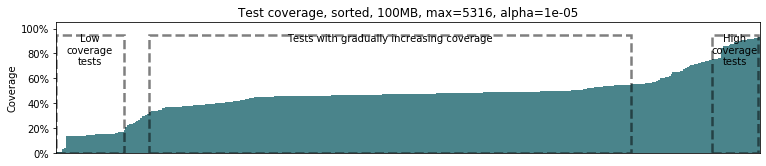

In [80]:
def renderDetections(tests_srt, selection, alpha=1e-5, desc='', data_src=lambda x: x[1], 
                     ylim=None, fname=None, x_data=None, rwidth=1.0, rheight=1.0, 
                     should_sort=False, do_coverage=False, test_mapping=None):
    
    filtered_tests = filterTests(project_tests(tests_srt, selection))
    tests_detections = get_detections(filtered_tests, alpha)
    fig, ax = pyplot.subplots(figsize=(rwidth*6*3, rheight*2*3))
    ax.tick_params(axis='x', labelrotation=90)
    coverage_max = comp_coverage(filtered_tests, alpha) if do_coverage else 100
    
    def evalfnc(x):
        return 100.0 * x / coverage_max
    
    if should_sort:
        tests_detections, perm = sorted_perm(tests_detections, key=lambda x: evalfnc(data_src(x)))
    
    x_data_orig = [x[0] for x in tests_detections]
    y_data = [evalfnc(data_src(x)) for x in tests_detections]
    x_data, y_data = fill_x_data(x_data_orig, y_data, x_data, lambda x: -1, sorted_add=None if not should_sort else -1) if x_data else (x_data_orig, y_data)
    
    # X axis labels sanitization
    cxx = process_test_x_axis(x_data, test_mapping, keep_battery=True)
    
    #for ix, x in enumerate(x_data):
    #    print('  %s: %s' % (x, y_data[ix]))
    
    # cxx = [shortenTest(x) for x in x_data]
    colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
    plt0 = sns.barplot(x=cxx, y=y_data, color=colors[4], saturation=1.0, linewidth=0.0)
        
    # plt.legend(loc='best')
    plt.title("%s, alpha=%s" % (desc, alpha))
    ax.set_ylabel("Coverage" if do_coverage else "Rejections")  
    if do_coverage:
        ax.set_yticklabels(['%.0f%%' % x for x in ax.get_yticks() if x <= 100])
    
    # Special sorted annotated version with coverage
    if should_sort and do_coverage:  # annotations
        newwidth = 1.0
        for bar in plt0.patches:     # resize bars
            x, width = bar.get_x(), bar.get_width()
            centre = x+width/2.
            bar.set_x(centre-newwidth/2.)
            bar.set_width(newwidth)
        
        ax.get_xaxis().set_visible(False)
        sections = [(0, 18), (33, 55), (75, 100)]
        ptches = list(plt0.patches)
        categorizer = lambda x: list(itertools.dropwhile(
            lambda x: not x[1], 
            list(zip(range(len(sections)), [x>=sec[0] and x<=sec[1] for sec in sections]))
        ))
        categorizerIdx = lambda x: categorizer(x)[0][0] if categorizer(x) else None
        offset = 0
        sec_portions = []
        for idx, (k,g) in enumerate(itertools.groupby(y_data, key=categorizerIdx)):
            g = list(g)
            offset += len(g)
            if k is None: continue
            sec_portions.append((offset-len(g), offset))

        for idx, pp in enumerate(sec_portions):
            pstart, pstop = ptches[pp[0]], (ptches[pp[1]] if len(ptches)>pp[1] else ptches[-1]) 
            xy = (pstart.get_x(), 0)
            cwidth = pstop.get_x() - pstart.get_x()
            rct = matplotlib.patches.Rectangle(xy,  width=cwidth, height=95,
                                               fill=False, alpha=0.5, ls='--', lw=2.5)
            ax.add_patch(rct)
            ctxt = 'Low\ncoverage\ntests' if idx == 0 else 'Tests with gradually increasing coverage'
            if idx == 2:
                ctxt = 'High\ncoverage\ntests'
            ax.annotate(ctxt, (xy[0]+cwidth/2, 80),
                        ha='center', va='top', xytext=(0, 10), textcoords='offset points')
            
        recs = []
        for i in range(len(x_data)):
            recs.append((cxx[i], y_data[i], categorizerIdx(y_data[i])))
        #print(json.dumps(recs, indent=2))

    if ylim:
        ax.set_ylim(ylim if not do_coverage else (0,105.0))
        if not do_coverage and max(y_data) > ylim[1]:
            print('!! Warning! your y-limit is lower than maximal data point, %s, max %s' % (ylim[1], max(y_data)))
    if fname:
        #plt.tight_layout()
        plt.savefig(fname, bbox_inches='tight', dpi=400)
        plt.savefig(os.path.splitext(fname)[0] + '.png', bbox_inches='tight', dpi=400)
    
#############
detectionsAlpha = 1e-5  # Syso suggestion, comparative normalization to RTT
#renderDetections(tests_srt, tf_10mib, 1e-3, 'relative rejections, 10MB', data_src=lambda x: x[1])

# renderDetections(tests_srt, tf_10mib, detectionsAlpha, 'absolute rejections, 10MB, max=%s, off10,' % len(tests_srt[0][1]), 
#                  data_src=lambda x: x[3], ylim=[-10, 2700], fname='/tmp/absrej_10mb_1e-5.pdf',
#                  x_data=[x[0] for x in project_tests(tests_srt, tf_all)])
# renderDetections(tests_srt, tf_100mib, detectionsAlpha, 'absolute rejections, 100MB, max=%s, off10,' % len(tests_srt[0][1]), 
#                 data_src=lambda x: x[3], ylim=[-10, 2700], fname='/tmp/absrej_100mb_1e-5.pdf',
#                 x_data=[x[0] for x in project_tests(tests_srt, tf_all)])
# 
# renderDetections(subtests_srt, tf_10mib, detectionsAlpha, 'absolute subtest rejections, 10MB, off10, max=%s' % len(tests_srt[0][1]), 
#                  data_src=lambda x: x[3], ylim=[-10, 2700], fname='/tmp/absrej_sub_10mb_1e-5.pdf',
#                  x_data=[x[0] for x in project_tests(subtests_srt, tf_all)], rwidth=3.5)
# renderDetections(subtests_srt, tf_100mib, detectionsAlpha, 'absolute subtest rejections, 100MB, off10, max=%s' % len(tests_srt[0][1]), 
#                 data_src=lambda x: x[3], ylim=[-10, 2700], fname='/tmp/absrej_sub_100mb_1e-5.pdf',
#                 x_data=[x[0] for x in project_tests(subtests_srt, tf_all)], rwidth=3.5)
# 
renderDetections(subtests_srt, tf_100mib, detectionsAlpha, 'Test coverage, sorted, 100MB, max=%s' % len(tests_srt[0][1]), 
                 data_src=lambda x: x[3], ylim=[-10, 2700], fname='/tmp/cov_sub_100mb_1e-5_sorted.pdf',
                 rwidth=0.7, rheight=0.4,
                 do_coverage=True, should_sort=True, test_mapping=subtests_map)
# 
# renderDetections(tests_srt, tf_10mib, detectionsAlpha, 'coverage test, 10MB, off10, max=%s' % len(tests_srt[0][1]), 
#                  data_src=lambda x: x[3], ylim=[-10, 2700], fname='/tmp/coverage_test_10mb_1e-5.pdf',
#                  x_data=[x[0] for x in project_tests(tests_srt, tf_all)], rwidth=1.0, rheight=0.5, do_coverage=True)
# 
# renderDetections(subtests_srt, tf_10mib, detectionsAlpha, 'coverage subtest, 10MB, off10, max=%s' % len(tests_srt[0][1]), 
#                  data_src=lambda x: x[3], ylim=[-10, 2700], fname='/tmp/coverage_sub_10mb_1e-5.pdf',
#                  x_data=[x[0] for x in project_tests(subtests_srt, tf_all)], rwidth=3.5, rheight=0.5, do_coverage=True)
# 
# renderDetections(tests_boolhyb_srt, tf_10mib, detectionsAlpha, 'coverage test, 10MB, off10, max=%s' % len(tests_srt[0][1]), 
#                  data_src=lambda x: x[3], ylim=[-10, 2700], fname='/tmp/coverage_testb_10mb_1e-5.pdf', 
#                  rwidth=1.0, rheight=0.5, do_coverage=True)


Plotting 0
.. 0, cp len: 387
[(0, 37), (51, 316), (361, 387)] 0


IndexError: list index out of range

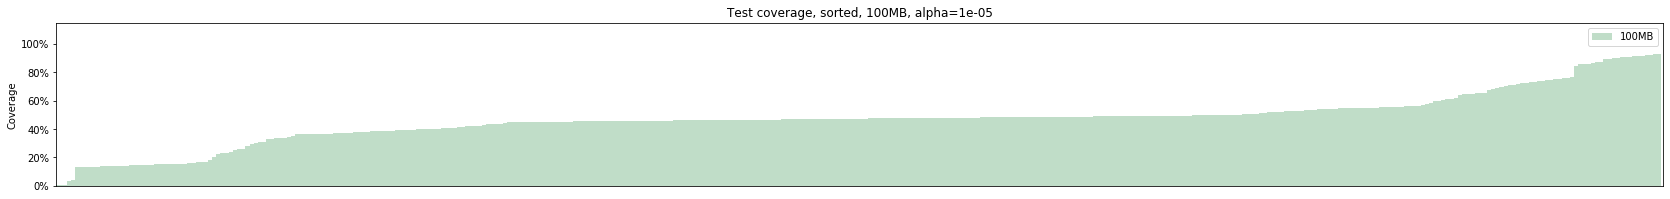

In [76]:
def renderSortedCoverage(tests_inp, selections, labels=None, 
                         alpha=1e-5, desc='', data_src=lambda x: x[1], 
                         ylim=None, fname=None, x_data=None, rwidth=1.0, rheight=1.0, 
                         test_mapping=None):
    
    filtered_tests = filterTests(tests_inp)
    data_inps = [project_tests(filtered_tests, x0) for x0 in selections]    
    tests_detections = [get_detections(x0, alpha) for x0 in data_inps]
    coverages = [comp_coverage(ct, alpha) for ct in data_inps]
    
    fig, ax = pyplot.subplots(figsize=(rwidth*6*3, rheight*2*3))
    ax.tick_params(axis='x', labelrotation=90)
    colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
    
    def evalfnc(x, cov):
        return 100.0 * x / cov
    
    if not x_data:
        all_sel = functools.reduce(lambda x,y: [x[i]|y[i] for i in range(len(x))], selections)
        x_data = [x[0] for x in project_tests(filtered_tests, all_sel)]
    
    x_lens = [len(x) for x in tests_detections]
    len_max = max(x_lens)
    
    # sorting
    plots = [None] * len(tests_detections)
    y_datas = [None] * len(tests_detections)
    x_datas = [None] * len(tests_detections)
    ptches = []
    ptches_all = []
    for idx, tdet in reversed(list(enumerate(tests_detections))):
        print('Plotting %s' % idx)
        tdet, perm = sorted_perm(tdet, key=lambda x: evalfnc(data_src(x), coverages[idx]))
        tests_detections[idx] = tdet
        x_data = [x[0] for x in tdet]
        y_data = [evalfnc(data_src(x), coverages[idx]) for x in tdet]
        
        to_insert = len_max - len(x_data)
        ins_ratio = len(x_data) / to_insert if to_insert else None
        for i in range(to_insert):
            ii = int(i * ins_ratio)
            x_data.insert(ii, '%s-%s' % (idx, i))
            y_data.insert(ii, y_data[ii - 1 if ii > 0 else ii + 1])
        
        cxx = process_test_x_axis(x_data, test_mapping, keep_battery=False)
        plt0 = sns.barplot(x=cxx, y=y_data, color=colors[2+2*idx], saturation=1.0, linewidth=0.0, label=labels[idx])
        plots[idx], y_datas[idx], x_datas[idx] = plt0, y_data, cxx
        
        if idx == 1:
            ptches = list(plt0.patches)
        
        cpatches = [x for x in plt0.patches if x not in ptches_all]
        newwidth = 1.0
        print('.. %s, cp len: %s' % (idx, len(cpatches)))
        for bar in cpatches:     # resize bars
            x, width = bar.get_x(), bar.get_width()
            centre = x+width/2.
            bar.set_x(centre-newwidth/2.)
            bar.set_width(newwidth)
            if idx == 0:
                r, g, b, a = bar.get_facecolor()
                bar.set_facecolor((r, g, b, .5))
        ptches_all += cpatches
        
    plt.legend(loc='best')
    plt.title("%s, alpha=%s" % (desc, alpha))
    ax.set_ylabel("Coverage")  
    ax.set_ylim((0,115.0))
    ax.set_xlim((0,len_max))
    ax.get_xaxis().set_visible(False)
    ax.set_yticklabels(['%.0f%%' % x for x in ax.get_yticks() if x <= 100])
    
    # 100 MB annotation
    sections = [(0, 18), (33, 55), (75, 100)]
    categorizer = lambda x: list(itertools.dropwhile(
        lambda x: not x[1], 
        list(zip(range(len(sections)), [x>=sec[0] and x<=sec[1] for sec in sections]))
    ))
    categorizerIdx = lambda x: categorizer(x)[0][0] if categorizer(x) else None
    offset = 0
    sec_portions = []
    for idx, (k,g) in enumerate(itertools.groupby(y_datas[-1], key=categorizerIdx)):
        g = list(g)
        offset += len(g)
        if k is None: continue
        sec_portions.append((offset-len(g), offset))
    
    print(sec_portions, len(ptches))
    for idx, pp in enumerate(sec_portions):
        pstart, pstop = ptches[pp[0]], (ptches[pp[1]] if len(ptches)>pp[1] else ptches[-1]) 
        xy = (pstart.get_x(), 0)
        cwidth = pstop.get_x() - pstart.get_x()
        print(idx, pp, xy, cwidth, pstart, pstop)
        
        rct = matplotlib.patches.Rectangle(xy,  width=cwidth, height=95,
                                           fill=False, alpha=0.5, ls='--', lw=2.5)
        ax.add_patch(rct)
        ctxt = 'Low\ncoverage\ntests' if idx == 0 else 'Tests with gradually increasing coverage'
        if idx == 2:
            ctxt = 'High\ncoverage\ntests'
        ax.annotate(ctxt, (xy[0]+cwidth/2, 70),
                    ha='center', va='top', xytext=(0, 20), textcoords='offset points')

    #recs = []
    #for i in range(len(x_data)):
    #    recs.append((cxx[i], y_data[i], categorizerIdx(y_data[i])))
    #print(json.dumps(recs, indent=2))

    if fname:
        #plt.tight_layout()
        plt.savefig(fname, bbox_inches='tight', dpi=400)
        plt.savefig(os.path.splitext(fname)[0] + '.png', bbox_inches='tight', dpi=400)
    
#############
detectionsAlpha = 1e-5  # Syso suggestion, comparative normalization to RTT
#renderSortedCoverage(subtests_srt, (tf_10mib, tf_100mib), labels=['10MB', '100MB'], 
#                     alpha=detectionsAlpha, 
#                     desc='Test coverage, sorted, 10MB, 100MB', 
#                     data_src=lambda x: x[3], 
#                     fname='/tmp/cov_sub_100mb_1e-5_sorted.pdf',
#                     rwidth=1.7, rheight=0.5, test_mapping=subtests_map)
renderSortedCoverage(subtests_srt, (tf_100mib,), labels=['100MB'], 
                    alpha=detectionsAlpha, 
                    desc='Test coverage, sorted, 100MB', 
                    data_src=lambda x: x[3], 
                    fname='/tmp/cov_sub_100mb_1e-5_sorted.pdf',
                    rwidth=1.6, rheight=0.5, test_mapping=subtests_map)

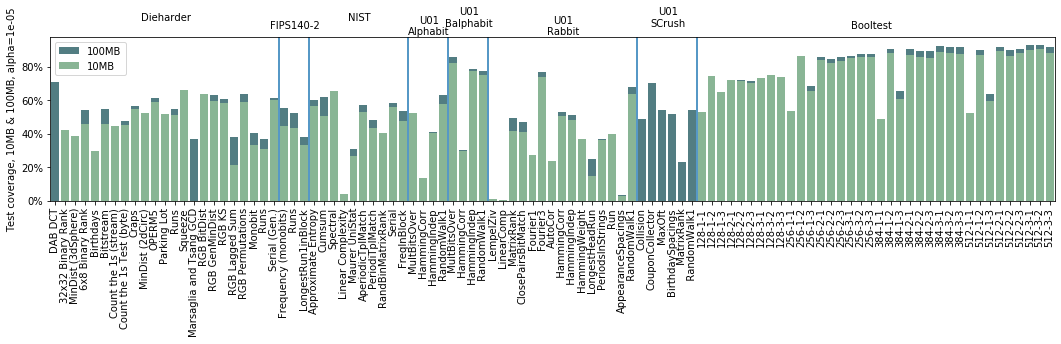

In [73]:
# Coverage testf
def renderCoverageGraph(tests_inp, selections, labels=None, test_mapping={}, alpha=1e-5, desc='', 
                        data_src=lambda x: x[1], ylim=None, fname=None, x_data=None, 
                        rwidth=1.0, rheight=1.0, should_sort=False, do_coverage=False):
    filtered_tests = filterTests(tests_inp)
    
    special = ['Frequency (monobits) test', 'Runs Test', 'Test for the Longest Run of Ones in a Block']
    def sorter(a, b):
        if a[0] != b[0]: return 0
        if not a[0].startswith('NIST'): return 0
        asp, bsp = a[1] in special, b[1] in special
        if asp and not bsp: return -1
        if not asp and bsp: return 1
        if not asp and not bsp: return 0
        if asp and bsp: return (a > b) - (a < b)

    filtered_tests = sorted(filtered_tests, key=lambda x: cmp_to_key(sorter)(x[0]))
    for i in range(len(filtered_tests)):
        if filtered_tests[i][0][1] in special:
            nkey = tuple(['FIPS140-2'] + list(filtered_tests[i][0][1:]))
            filtered_tests[i] = nkey, filtered_tests[i][1]
    
    data_inps = [project_tests(filtered_tests, x0) for x0 in selections]    
    tests_detections = [get_detections(x0, alpha) for x0 in data_inps]
    coverages = [comp_coverage(ct, alpha) for ct in data_inps]
    
    fig, ax = pyplot.subplots(figsize=(rwidth*6*3, rheight*2*3))
    ax.tick_params(axis='x', labelrotation=90)
    
    if not x_data:
        all_sel = functools.reduce(lambda x,y: [x[i]|y[i] for i in range(len(x))], selections)
        x_data = [x[0] for x in project_tests(filtered_tests, all_sel)]
    
    bat_indices = [get_battery_idx(x) for x in x_data]
    bat_bounds = [0]
    for k,g in itertools.groupby(bat_indices):
        bat_bounds.append(bat_bounds[-1] + len(list(g)))
    
    y_dat_vct = []
    for idx, yy in enumerate(tests_detections):
        cx = [x[0] for x in yy]
        cy = [(100.0 * data_src(x) / coverages[idx]) for x in yy]
        nx, y_data = fill_x_data(cx, cy, x_data, lambda x: 0, sorted_add=None if not should_sort else -1)
        y_dat_vct.append(y_data)
    
    # X axis labels sanitization
    cxx = process_test_x_axis(x_data, test_mapping, keep_battery=False)
    
    colors = sns.cubehelix_palette(8, start=.5, rot=-.75)  # sns.color_palette()
    patches = []
    for idx in reversed(range(len(selections))):
        plt0 = sns.barplot(x=list(cxx), y=y_dat_vct[idx], 
                           color=colors[2] if idx==0 else colors[4], 
                           label=labels[idx] if labels else str(idx))
        patches = plt0.patches
    
    axx = ax
    for idx in range(1, len(bat_bounds)):
        i = bat_bounds[idx]
        is_last = idx + 1 >= len(bat_bounds)
        
        c0,c1 = (patches[i], patches[i+1]) if not is_last else (patches[i-1], patches[i])
        cm1x = patches[bat_bounds[idx-1]].get_x() if idx > 0 else 0
        
        if not is_last:
            ax.axvline(c0.get_x() - ((c1.get_x() - c0.get_x() - c0.get_width()))/2)
        
        cwidth = (c0.get_x()-cm1x)
        ctxt = get_short_bat(bat_indices[i-1])
        ctxt = ctxt.replace(' ', '\n') if 'U01' in ctxt else ctxt
        #ctxt = '\n'.join(textwrap.wrap(ctxt, int(2*cwidth)))
        cyy = axx.axis()[-1]
        cyy += 0 if idx & 1 else -5
        ax.annotate(ctxt, (c0.get_x() - cwidth/2, cyy),
                    ha='center', va='center', xytext=(0, 20), textcoords='offset points')
    
    plt.legend(loc='best')
    ax.set_ylabel("%s, alpha=%s" % (desc, alpha))  
    ax.set_yticklabels(['%.0f%%' % x for x in ax.get_yticks() if x <= 100])
    if ylim:
        ax.set_ylim(ylim if not do_coverage else (0,110.0))
    if fname:
        #plt.tight_layout()
        plt.savefig(fname, bbox_inches='tight', dpi=400)
        plt.savefig(os.path.splitext(fname)[0] + '.png', bbox_inches='tight', dpi=400)
    
    
######################################################################################################
renderCoverageGraph(tests_boolhyb_srt, (tf_10mib, tf_100mib), labels=['10MB', '100MB'], 
                    alpha=1e-5, test_mapping=tests_boolhyb_map,
                    desc='Test coverage, 10MB & 100MB', data_src=lambda x: x[3], rheight=0.5,
                    fname='/tmp/coverage_test_10mb_100mb_1e-5.pdf')

Uniqueness min: 3615, max: 10227, scale: 0.015124016938898971, max_pts: 1026231
['U01BA|HammingIndep|8|1', 'booltest-128-3-3', 'U01BA|HammingIndep|7|1', 'booltest-128-3-2', 'U01BA|HammingIndep|2|1', 'U01BA|MultBitsOver|19|1', 'U01BA|MultBitsOver|13|1', 'U01BA|HammingIndep|1|1', 'U01R|Fourier3|1|1', 'booltest-256-2-2', 'booltest-256-2-3', 'booltest-256-2-1', 'booltest-256-1-2', 'booltest-256-3-1', 'booltest-256-3-2', 'booltest-256-3-3', 'booltest-384-2-2', 'booltest-384-2-3', 'booltest-512-1-2', 'booltest-512-2-2', 'booltest-384-1-2', 'booltest-384-2-1', 'booltest-512-2-3', 'booltest-384-3-2', 'booltest-384-3-3', 'booltest-512-2-1', 'booltest-512-3-3', 'booltest-384-3-1', 'booltest-512-3-1', 'booltest-512-3-2']


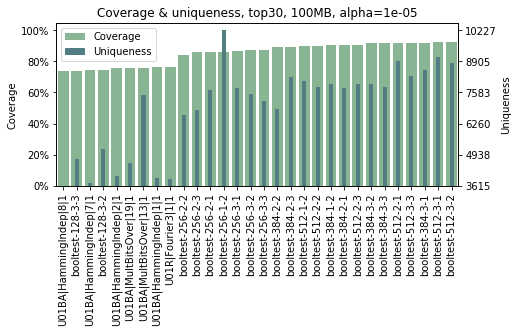

In [74]:
def renderCovUniqGraph(test_proc, alpha=1e-5, desc='', data_src=lambda x: x[1], 
                       ylim=None, fname=None, rwidth=1.0, rheight=1.0, 
                       should_sort=False, do_coverage=False, test_mapping=None, topx=None):
    
    selection = test_proc.selection
    filtered_tests = test_proc.ctests
    tests_detections = get_detections(filtered_tests, alpha)
    fig, ax = pyplot.subplots(figsize=(rwidth*6*3, rheight*2*3))
    ax.tick_params(axis='x', labelrotation=90)
    
    coverage_max = comp_coverage(filtered_tests, alpha) if do_coverage else 100
    uniq_scoring = [test_proc.tests_scoring1off[i] for i in range(test_proc.num_tests)]

    def evalfnc(x):
        return 100.0 * x / coverage_max
    
    if should_sort:
        tests_detections, perm = sorted_perm(tests_detections, key=lambda x: evalfnc(data_src(x)))
        uniq_scoring = apply_permutation(uniq_scoring, perm)
    
    x_data = [x[0] for x in tests_detections]
    y_data = [evalfnc(data_src(x)) for x in tests_detections]
    if topx:
        y_data = y_data[-topx:]
        x_data = x_data[-topx:]
        uniq_scoring = uniq_scoring[-topx:]
    
    minuni, maxuni = min(uniq_scoring), max(uniq_scoring)
    uniwid = maxuni - minuni
    uniscale = 100 / uniwid
    uniq_scaled = [(x - minuni) * uniscale for x in uniq_scoring]
    print('Uniqueness min: %s, max: %s, scale: %s, max_pts: %s' % (minuni, maxuni, uniscale, test_proc.num_max_points))
    
    cxx = process_test_x_axis(x_data, test_mapping, keep_battery=True)
    print(cxx)
    
    dfpre = []
    for i in range(len(x_data)):
        dfpre.append({'x':cxx[i], 'y':y_data[i], 'src':'Coverage'})
        dfpre.append({'x':cxx[i], 'y':uniq_scaled[i], 'src':'Uniqueness'})
    df = pd.DataFrame(dfpre)    
    #print(df)
    
    colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
    color1 = colors[2] + [0.5]
    color2 = colors[4] + [0.5]

    #sns.barplot(x='x', y='y', hue='src', data=df, palette=[colors[2], colors[4]])
    plt0 = sns.barplot(x=cxx, y=y_data, color=color1, label='Coverage')
    patches0 = list(plt0.patches)
    
    plt1 = sns.barplot(x=cxx, y=uniq_scaled, color=color2, label='Uniqueness')
    patches1 = [x for x in plt1.patches if x not in patches0]
    
    plt.legend(loc='best')
    newwidth = 0.3
    for bar in patches1:
        #r, g, b, a = bar.get_facecolor()
        #bar.set_facecolor((r, g, b, .5))
        x, width = bar.get_x(), bar.get_width()
        centre = x + width / 2.
        bar.set_x(centre - newwidth / 2.)
        bar.set_width(newwidth)
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticklabels([int(x) for x in np.ceil(minuni+ax.get_yticks()/uniscale)])
    ax2.set_ylabel('Uniqueness')
    
    plt.title("%s, alpha=%s" % (desc, alpha))
    ax.set_ylabel("Coverage") 
    ax.set_yticklabels(['%.0f%%' % x for x in ax.get_yticks() if x <= 100])
    if ylim:
        ax.set_ylim(ylim if not do_coverage else (0,105.0))
        if not do_coverage and max(y_data) > ylim[1]:
            print('!! Warning! your y-limit is lower than maximal data point, %s, max %s' % (ylim[1], max(y_data)))
    if fname:
        #plt.tight_layout()
        plt.savefig(fname, bbox_inches='tight', dpi=400)
        plt.savefig(os.path.splitext(fname)[0] + '.png', bbox_inches='tight', dpi=400)

#########################################################################################################
renderCovUniqGraph(subtest_analysis100, 1e-5, 
                   'Coverage & uniqueness, top30, 100MB', 
                   data_src=lambda x: x[3], ylim=[-10, 2700], fname='/tmp/cov_uniq_sub_100mb_1e-5_sorted.pdf',
                   rwidth=0.4, rheight=0.5,
                   do_coverage=True, should_sort=True, test_mapping=subtests_map, topx=30)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[[92.18662169758291, 94.37886453063518, 95.72793704328274, 96.79595278246205, 97.52670039347949, 98.03260258572232, 98.36987071388421, 98.65092748735245, 98.93198426082068, 99.10061832490163, 99.26925238898258, 99.38167509836987, 99.49409780775717, 99.55030916245082], [75.25, 75.25, 75.25, 75.25, 75.5, 75.25, 75.25, 75.5, 75.25, 76.0, 75.5, 76.0, 75.5, 85.0]]
Plotting 0
.. 0, cp len: 14
Plotting 1
.. 1, cp len: 14
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[[75.99775154581225, 83.24901630129285, 85.10399100618325, 86.6779089376054, 87.74592467678471, 88.36424957841484, 88.81394041596403, 89.20741989881957, 89.54468802698145, 89.8257448004497, 90.10680157391793, 90.27543563799888, 90.44406970207982, 90.61270376616076], [75.25, 75.25, 75.25, 75.25, 75.25, 75.25, 75.5, 75.25, 75.75, 77.25, 75.75, 82.25, 94.75, 95.75]]
Plotting 0
.. 0, cp len: 14
Plotting 1
.. 1, cp len: 14


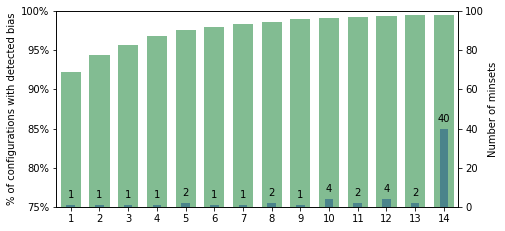

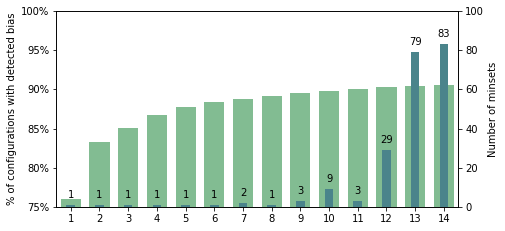

In [75]:
# figure 6 - minset
def renderMinset(data_fname, desc='', fname="", rwidth=1.0, rheight=1.0, labels=None):
    # minsets 1664 a 1779
    with open(data_fname, 'r') as fh:
        lines = [x for x in [x.strip() for x in fh.read().split('\n')] if x][1:]
        
    x_data = []
    y_data = [[], []]  # 
    max_coverage = 1779  # magic
    ybounds = (75, 100)
    
    for ix, line in enumerate(lines):
        data = [int(x.strip()) for x in line.split(',') if x]
        x_data.append(data[0])
        y_data[1].append(data[1])  # num of diff minsets
        y_data[0].append(100.0 * data[2] / max_coverage)  # num of configurations
    
    fig, ax = pyplot.subplots(figsize=(rwidth*6*3, rheight*2*3))
    colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
    
    plots = [None] * 2
    ptches = []
    ptches_all = []

    minuni, maxuni = 0, 100 #max(y_data[1]) * 1.18  #min(y_data[1]), max(y_data[1])
    uniwid = maxuni - minuni
    uniscale = (ybounds[1] - ybounds[0]) / uniwid
    y_data1_orig = list(y_data[1])
    y_data[1] = [ybounds[0] + (x - minuni) * uniscale for x in y_data[1]]
    
    print(x_data)
    print(y_data)
    for idx in range(2):
        print('Plotting %s' % idx)
        
        # cxx = process_test_x_axis(x_data, test_mapping, keep_battery=False)
        plt0 = sns.barplot(x=x_data, y=y_data[idx], color=colors[2+2*idx], 
                           saturation=1.0, linewidth=0.0, label=labels[idx])
        plots[idx] = plt0
        
        if idx == 1:
            ptches = list(plt0.patches)
        
        cpatches = [x for x in plt0.patches if x not in ptches_all]
        newwidth = 0.3 if idx == 1 else 0.7
        
        print('.. %s, cp len: %s' % (idx, len(cpatches)))
        for iix, bar in enumerate(cpatches):
            x, width = bar.get_x(), bar.get_width()
            centre = x + width / 2.
            bar.set_x(centre - newwidth / 2.)
            bar.set_width(newwidth)
            #if idx == 1:
            #   r, g, b, a = bar.get_facecolor()
            #   bar.set_facecolor((r, g, b, .5))
                
            if idx == 1:
                cx = bar.get_x()
                wi = bar.get_width()
                ct = cx + wi/2.
                #print(cx,wi,ct)
                ax.annotate('%s' % y_data1_orig[iix], (ct, bar.get_y() + bar.get_height()), 
                            ha='center', va='center', xytext=(0, 10), textcoords='offset points')
                
        ptches_all += cpatches
        
    #plt.legend(loc='best')#, framealpha=0.0, frameon=False)
    #plt.legend().get_frame().set_facecolor('none')
    #plt.legend().get_frame().set_linewidth(0.0)
    plt.title("%s" % (desc, ))
    ax.set_ylabel("% of configurations with detected bias")  
    ax.set_ylim(ybounds)
    ax.get_xaxis().set_visible(True)
    vals = ax.get_yticks()
    ax.set_yticklabels(['%.0f%%' % x for x in vals if x <= 100])
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticklabels([int(x) for x in np.ceil(minuni+(ax.get_yticks()-ybounds[0])/uniscale)])
    ax2.set_ylabel('Number of minsets')

    if fname:
        #plt.tight_layout()
        plt.savefig(fname, bbox_inches='tight', dpi=400)
        plt.savefig(os.path.splitext(fname)[0] + '.png', bbox_inches='tight', dpi=400)
    

#########################################################################################################
renderMinset('minset_stats_withBT_10-5.csv', rwidth=0.4, rheight=0.6,
             fname='/tmp/minset_stats_withBt-10-5.pdf',
             labels=[
                 "Fractions of configurations rejected by minset", 
                 "Number of different minsets"])

renderMinset('minset_stats_withoutBT_10-5.csv', rwidth=0.4, rheight=0.6,
             fname='/tmp/minset_stats_withoutBt-10-5.pdf',
             labels=[
                 "Fractions of configurations rejected by minset", 
                 "Number of different minsets"])

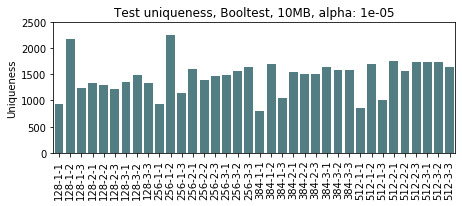

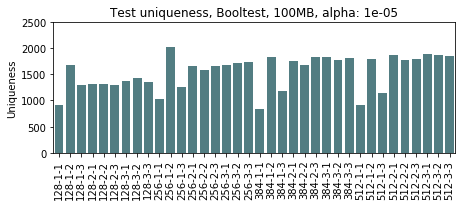

In [57]:
# T1 test uniqueness scoring
def renderTestScoring(test_analysis, desc=None, ylim=None, fname=None, x_data=None, 
                      rwidth=1.0, rheight=1.0, data_src=lambda x, y: x.tests_scoring1[y], 
                      test_mapping=None, filter_test_fnc=None, keep_battery=True):
    fig, ax = pyplot.subplots(figsize=(rwidth*6*3, rheight*2*3))
    ax.tick_params(axis='x', labelrotation=90)
    colors = sns.cubehelix_palette(8, start=.5, rot=-.75)
    color1 = colors[2] 
    color2 = colors[4] 
    
    _, filter_idx = filterTests(test_analysis.ctests, ret_idx=True)
    if filter_test_fnc:
        filter_idx = [filter_idx[x] and filter_test_fnc(test_analysis.ctests[x]) for x in range(len(test_analysis.ctests))]
    
    filtered_tests = list(itertools.compress(test_analysis.ctests, filter_idx))
    x_data_orig = [x[0] for x in filtered_tests]
    y_data = [data_src(test_analysis, x) for x in range(len(test_analysis.ctests))]
    y_data = list(itertools.compress(y_data, filter_idx))
    x_data, y_data = fill_x_data(x_data_orig, y_data, x_data, lambda x: -1) if x_data else (x_data_orig, y_data)
    cxx = process_test_x_axis(x_data, test_mapping, keep_battery=keep_battery) if test_mapping else [shortenTest(x) for x in x_data]
    
    sns.barplot(x=cxx, y=y_data, color=color2)
    desc_def = 'test scoring (the better the more unique appearances)'
    plt.title("%s, alpha: %s" % (desc if desc else desc_def, test_analysis.alpha))
    ax.set_ylabel("Uniqueness")
    
    if ylim:
        ax.set_ylim(ylim)
        if max(y_data) > ylim[1]:
            print('!! Warning! your y-limit is lower than maximal data point, %s, max %s' % (ylim[1], max(y_data)))
    if fname:
        #plt.tight_layout()
        plt.savefig(fname, bbox_inches='tight', dpi=400)
        plt.savefig(os.path.splitext(fname)[0] + '.png', bbox_inches='tight', dpi=400)
    
###########################
x_data=[x[0] for x in project_tests(tests_srt, tf_all)]
x_sdata=[x[0] for x in project_tests(subtests_srt, tf_all)]
x_sbdata=[x[0] for x in project_tests(tests_boolhyb_srt, tf_all)]
data_src = lambda x, y: x.tests_scoring1off[y]
data_srcr = lambda x, y: x.tests_scoring1[y]

# renderTestScoring(test_analysis10, desc='test scoring (the better the more unique appearances), off10, 10MB', 
#                   x_data=x_data, fname='/tmp/uniqScoreTest10.pdf', data_src=data_src, ylim=[-10, 79000])
# renderTestScoring(test_analysis100, desc='test scoring (the better the more unique appearances), off10, 100MB', 
#                   x_data=x_data, fname='/tmp/uniqScoreTest100.pdf', data_src=data_src, ylim=[-10, 79000])

renderTestScoring(tests_bools_analysis10, desc='Test uniqueness, BoolTest, 10MB', 
                  fname='/tmp/uniqScoreTestB10.pdf', data_src=data_srcr, 
                  rwidth=0.4, rheight=0.4, ylim=[0, 2500], test_mapping=tests_boolhyb_map, keep_battery=False,
                  filter_test_fnc=lambda x: 'booltest' in x[0][0])
renderTestScoring(tests_bools_analysis100, desc='Test uniqueness, BoolTest, 100MB', 
                  fname='/tmp/uniqScoreTestB100.pdf', data_src=data_srcr,
                  rwidth=0.4, rheight=0.4, ylim=[0, 2500], test_mapping=tests_boolhyb_map, keep_battery=False,
                  filter_test_fnc=lambda x: 'booltest' in x[0][0])

# renderTestScoring(subtest_analysis10, desc='subtest scoring (the better the more unique appearances), off10, 10MB', 
#                   x_data=x_sdata, fname='/tmp/uniqScoreSubtest10.pdf', rwidth=3.5, data_src=data_src, ylim=[-10, 17000], test_mapping=subtests_map)
# renderTestScoring(subtest_analysis100, desc='subtest scoring (the better the more unique appearances), off10, 100MB', 
#                   x_data=x_sdata, fname='/tmp/uniqScoreSubtest100.pdf', rwidth=3.5, data_src=data_src, ylim=[-10, 17000], test_mapping=subtests_map)

In [35]:
subtest_boolhyb_analysis10

In [ ]:
# TODO: filter top 3 strongest and top 3 lowest tests, 10, 100 and 8 GB

In [ ]:
#loader.batteries[20010].tests[200545].variants[501513].sub_tests[1081150].stats
#loader.batteries[20010].tests[200545].summarized_pvals

Total detections: 366804, defined: 344363
Alpha: 0.00100000, detections: 106740, relative: 0.30996361397711136
Alpha: 0.00500000, detections: 109922, relative: 0.3192038633651118
Alpha: 0.01000000, detections: 112574, relative: 0.3269050391592593
Alpha: 0.05000000, detections: 124174, relative: 0.3605904234775513
Alpha: 0.10000000, detections: 137332, relative: 0.3988001033792829
Alpha: 0.25000000, detections: 169879, relative: 0.49331374160406316
Alpha: 0.50000000, detections: 222623, relative: 0.6464776994044076
Alpha: 0.75000000, detections: 276413, relative: 0.8026791496182807
Alpha: 1.00000000, detections: 344363, relative: 1.0


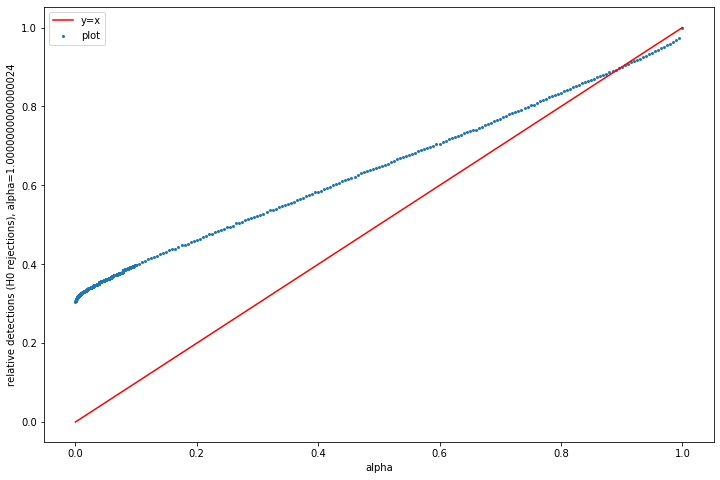

In [27]:
def renderPvalGraph(tests_srt, selection, step=0.0001, alpha=0.0001, desc=None, alpha_top=1.0):
    ctests = project_tests(tests_srt, selection)
    total_det = sum(selection) * len(tests_srt)
    tests_undefined = collections.defaultdict(lambda: 0)  # tname -> # of NONE in test
    total_def_det = 0

    # Fails removal & report
    for tname, tvals in ctests:
        for idx, tval in enumerate(tvals):
            if tval is None:
                eidx = get_ex_byidx(selection, idx)
                tests_undefined[tname] += 1
                #print('%s : %s' % (tname, exps[eidx].name))
            else:
                total_def_det += 1

    print('Total detections: %s, defined: %s' % (total_det, total_def_det))


    x_data = []
    y_data = []
    while alpha <= alpha_top:
        alpha += step

        tests_detections = [(x[0], sum(1 for y in x[1] if y is not None and y < alpha)) for x in ctests]
        detections = sum([x[1] for x in tests_detections])

        if min([abs(alpha - x) for x in [0.005, 0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.]]) <= 0.000001:
            print('Alpha: %0.8f, detections: %s, relative: %s' % (alpha, detections, float(detections)/total_def_det if total_def_det > 0 else 0))
        if alpha > 0.1:
            step = 0.005

        x_data.append(alpha)
        #y_data.append(float(detections))
        #y_data.append(alpha / (float(detections)/total_def_det))
        #y_data.append((float(detections)/total_def_det) / alpha)
        y_data.append((float(detections)/total_def_det) if total_def_det else 0)

    fig, ax = pyplot.subplots(figsize=(6*2, 4*2))
    plt.scatter(x_data, 
                y_data, 
                label='plot', s=4)
    plt.plot(x_data, x_data, label='y=x', color='red')
    plt.legend(loc='best')  # plt.tick_params(labelsize=14)
    ax.set_xlabel("alpha")
    ax.set_ylabel("relative detections (H0 rejections)%s, alpha=%s" % (', ' + desc if desc else '', alpha))
    # TODO: compute KS

############
renderPvalGraph(tests_srt, tf_all, 0.0001, 1e-4)

## Vertical scoring

In [ ]:
# Idea: work in the test matrix in columns, count number of test reports per data set and assign points.
# Tests ranking results together.
# T1: per data: score tests. N points, divide between activated tests
# T2: per data: add tests to the set. if set exists, increment number. Which are the most often sets?
# T3: per data: triangular matrix of N tests. add +1 to a test which fired together. Which are the most firing tests?

In [ ]:
exps[0].exp_info.id

Grouping: [('AES', 104857600), ('ARIA', 104857600), ('ARIRANG', 104857600), ('BLAKE', 104857600)]
Experiments: test rejections / all tests with alpha: 5e-05
Function: max round achieved: alpha=5e-05, desc=100MB, off10
[
  ["('AES', 'ctr', '07b6da49541c5c1c')": [1, 2, 3, 4]],
  ["('AES', 'ctr', '4464a22651888b31')": [1, 2, 3, 4]],
  ["('AES', 'ctr', '874f2da1f4dabcaf')": [1, 2, 3, 4]],
  ["('AES', 'hw', '07b6da49541c5c1c')": [1, 2, 3, 4]],
  ["('AES', 'hw', '4464a22651888b31')": [1, 2, 3, 4]],
  ["('AES', 'hw', '874f2da1f4dabcaf')": [1, 2, 3, 4]],
  ["('AES', 'sac', '07b6da49541c5c1c')": [1, 2, 3, 4]],
  ["('AES', 'sac', '4464a22651888b31')": [1, 2, 3, 4]],
  ["('AES', 'sac', '874f2da1f4dabcaf')": [1, 2, 3, 4]],
  ["('ARIA', 'ctr', '07b6da49541c5c1c')": [1, 2, 3]],
  ["('ARIA', 'ctr', '4464a22651888b31')": [1, 2, 3]],
  ["('ARIA', 'ctr', '874f2da1f4dabcaf')": [1, 2, 3]],
  ["('ARIA', 'hw', '07b6da49541c5c1c')": [1, 2, 3]],
  ["('ARIA', 'hw', '4464a22651888b31')": [1, 2, 3]],
  ["('ARIA'

    Skipped: ('MARS', 'ctr', '07b6da49541c5c1c'), booltest|booltest|0|2
    Skipped: ('MARS', 'ctr', '07b6da49541c5c1c'), booltest|booltest|0|31
    Skipped: ('MARS', 'ctr', '4464a22651888b31'), booltest|booltest|0|9
    Skipped: ('MARS', 'ctr', '4464a22651888b31'), booltest|booltest|0|11
    Skipped: ('MARS', 'ctr', '4464a22651888b31'), booltest|booltest|0|12
    Skipped: ('MARS', 'ctr', '4464a22651888b31'), booltest|booltest|0|15
    Skipped: ('MARS', 'ctr', '4464a22651888b31'), booltest|booltest|0|18
    Skipped: ('MARS', 'ctr', '4464a22651888b31'), booltest|booltest|0|28
    Skipped: ('MARS', 'ctr', '874f2da1f4dabcaf'), booltest|booltest|0|11
    Skipped: ('MARS', 'hw', '07b6da49541c5c1c'), booltest|booltest|0|27
    Skipped: ('MARS', 'hw', '07b6da49541c5c1c'), booltest|booltest|0|30
    Skipped: ('MARS', 'hw', '07b6da49541c5c1c'), booltest|booltest|0|31
    Skipped: ('MARS', 'hw', '4464a22651888b31'), booltest|booltest|0|3
    Skipped: ('MARS', 'hw', '4464a22651888b31'), booltest|

NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|5: 895
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|6: 839
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|7: 848
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|8: 891
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|9: 898
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|10: 863
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|11: 869
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|12: 819
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|13: 870
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|14: 865
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|15: 842
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|16: 894
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|17: 858
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|18: 871
NSTS|Non-overlapping (Aperiodic) Template Matching Test|1|19: 821
NSTS|Non-overla

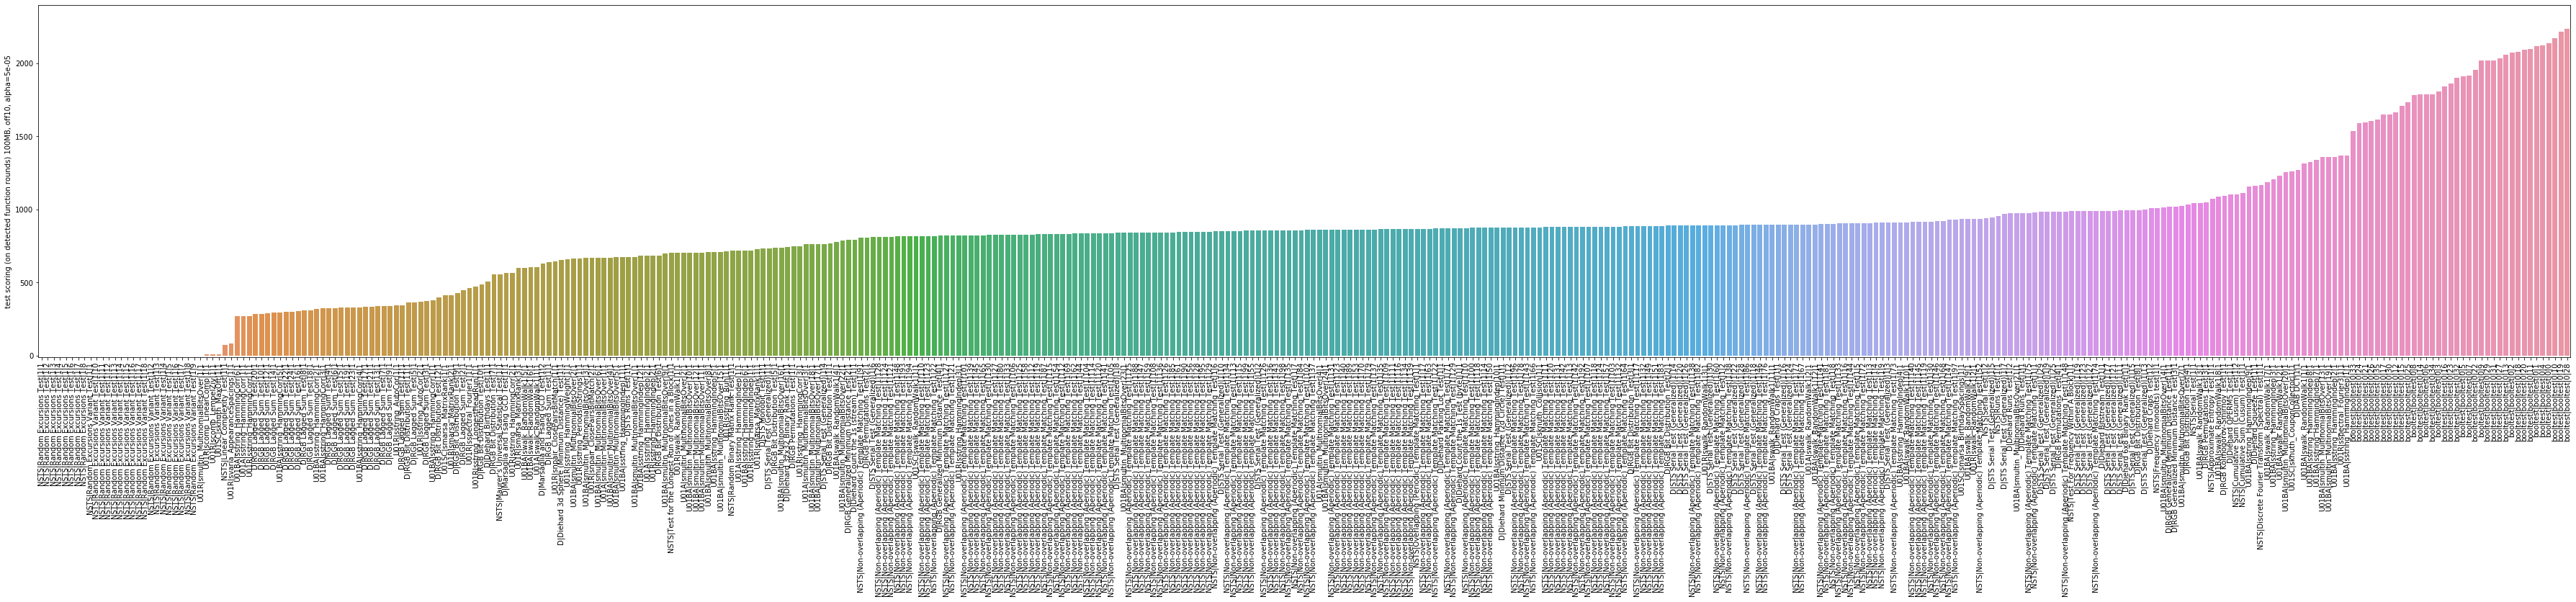

In [48]:
# Scoring by rounds achieved
def get_rounds_agg(exps, agg=lambda x: x.exp_info.fnc_name):
    f2r = collections.defaultdict(lambda: [])
    for x in exps:
        f2r[agg(x)].append(x.exp_info.fnc_round)
    return f2r

def round_scoring(exps, tests_srt, selection, alpha=1e-3, desc=None, gwidth=1.0, gfname=None, ylim=None, x_data=None, 
                 use_off=False, use_sort=True):
    ctests = filterTests(project_tests(tests_srt, selection))
    total_det = sum(selection) * len(tests_srt)
    tests_undefined = collections.defaultdict(lambda: 0) 
    num_tests = len(ctests)
    expmap = {x.id: x for x in exps}
    exps_sel = [x for i, x in enumerate(exps) if selection[i]]
    
    # Manual outlier test
    if False:
        for x in ctests:
            print('%s: %s' % (x[0], sum([1 for y in x[1] if y is not None])))
            if 'scomp_LinearComp' in x[0]:
                print(x)
        return
    
    agg = lambda x: x.exp_info.fnc_name  # old way - just function name bucket
    agg = lambda x: (
        x.exp_info.fnc_name, 
        x.exp_info.meth,
        x.exp_info.seed)
    
    fnc_rounds = get_rounds_agg(exps_sel, agg)
    f2r = collections.defaultdict(lambda: [])  # fname -> [(exp, exp_ord)]
    for ix, x in enumerate(exps_sel):
        f2r[agg(x)].append((x, ix))

    # fname -> [(exp, exp_ord)], sorted
    f2r_map = {fname: sorted(f2r[fname], key=lambda x: (x[0].exp_info.fnc_round, x[0].exp_info.meth, agg(x[0]))) for fname in f2r}

    # testidx -> fname -> top round achieved
    TEST_ROUNDS_NO_DATA = -10  # no pvalue was found for (test, fname) 
    TEST_ROUNDS_NO_ROUND = -1  # (test, fname) has data, but >= alpha for each tested round
    test_rounds = collections.defaultdict(
        lambda: collections.defaultdict(
            lambda: TEST_ROUNDS_NO_DATA))
    
    # set of rejected rounds
    test_rounds_set = collections.defaultdict(  
        lambda: collections.defaultdict(
            lambda: set()))
    
    fnc_rejected_rounds = collections.defaultdict(lambda: -1)
    fnc_rejected_rounds_set = collections.defaultdict(lambda: set())
    test_occurences = collections.defaultdict(lambda: 0)
    test_undefined = collections.defaultdict(lambda: 0)
    test_undefineds = collections.defaultdict(lambda: [])
    test_defined = collections.defaultdict(lambda: 0)
    test_detected = collections.defaultdict(lambda: 0)
    data_rounds = collections.defaultdict(lambda: [0,0,[]])  # expid -> (# tests checked, # tests rejects)

    for fname in f2r_map:
        for exp, exid in f2r_map[fname]:
            nexid = exid #  get_ex_newidx(selection, exid)  # after compression by selection
            # if nexid is None:
            #    continue
                
            fround = exp.exp_info.fnc_round
            for testid in range(len(ctests)):
                tname = ctests[testid][0]
                pvals = ctests[testid][1]
                
                test_occurences[testid] += 1
                if pvals[nexid] is None:
                    test_undefined[testid] += 1
                    test_undefineds[testid].append(exp)
                else:
                    test_defined[testid] += 1
                
                if pvals[nexid] is not None:
                    if pvals[nexid] < alpha:
                        test_detected[testid] += 1
                        test_rounds[testid][fname] = max(fround, test_rounds[testid][fname])
                        test_rounds_set[testid][fname].add(fround)
                        fnc_rejected_rounds[fname] = max(fround, fnc_rejected_rounds[fname])
                        fnc_rejected_rounds_set[fname].add(fround)
                    else:
                        test_rounds[testid][fname] = max(TEST_ROUNDS_NO_ROUND, test_rounds[testid][fname])
                    
                if pvals[nexid] is not None:
                    data_rounds[exp.id][0] += 1
                    if pvals[nexid] < alpha:
                        data_rounds[exp.id][1] += 1
                    data_rounds[exp.id][2].append((tname, pvals[nexid]))
    
    #
    # Dump: experiment -> pass/fail table
    #
    data_expids = sorted(list(data_rounds.keys()), key=lambda x: (
        expmap[x].exp_info.fnc_name, 
        expmap[x].exp_info.size, 
        expmap[x].exp_info.fnc_round, 
        expmap[x].exp_info.meth,
        expmap[x].exp_info.seed,
    ))
    
    exp_name_extractor = lambda x: (x.id, 
                           x.exp_info.id,
                           x.exp_info.fnc_name, 
                           x.exp_info.osize,
                           x.exp_info.fnc_round, 
                           x.exp_info.meth,
                           x.exp_info.seed[0:4])
    
    exp_namer = lambda x: '%s-e%s-%s-%s-r%s-%s-%s' % exp_name_extractor(x)
    
    data_round_groups = []
    data_round_groups_meta = []
    for k,g in itertools.groupby(data_expids, key=lambda x: (expmap[x].exp_info.fnc_name, expmap[x].exp_info.size)):
        data_round_groups.append(list(g))
        data_round_groups_meta.append(k)
    
    print('Grouping: %s' % data_round_groups_meta[0:4])
    print('Experiments: test rejections / all tests with alpha: %s' % alpha)
    data_rounds_agg = []
    data_rounds_txt = []
    data_rounds_total = 0
    data_rounds_graph = [[]]
    for grpidx, grp in enumerate(data_round_groups):
        #if len(data_rounds_graph[-1]) + len(grp) > 100:
        data_rounds_graph.append([])
            
        cgraph = data_rounds_graph[-1]
        for ix, expid in enumerate(grp):
            exp = expmap[expid]
            dt = data_rounds[expid]
            name_full = exp_namer(exp)
            name = '\n'.join(wrapHyphened(name_full, 50))
            cgraph.append([name, dt[1]/float(dt[0])])
            cline = ('%s .. %s / %s' % (name_full, dt[1], dt[0]))
            data_rounds_txt.append(cline)
            # print(cline)
            
            data_rounds_total += 1
            data_rounds_agg.append({
                'id':            exp.id, 
                'eid':           exp.exp_info.id,
                'fnc':           exp.exp_info.fnc_name, 
                'osize':         exp.exp_info.osize,
                'size':          exp.exp_info.size,
                'round':         exp.exp_info.fnc_round, 
                'method':        exp.exp_info.meth,
                'seed':          exp.exp_info.seed,
                'test_rej': dt[1],
                'test_all': dt[0],
                'test_res': dt[2],
            })
        
        #if data_rounds_total > 20:
        #    break
    
    fname_component = '-'.join(['e%s' % x for x in exp_id_list])
    data_rounds_graph = [x for x in data_rounds_graph if x]
    # json.dump(data_rounds_agg, open('/tmp/exps_data-%s.json' % fname_component, 'w+'), indent=2)
    # open('/tmp/exps_data-%s.txt' % fname_component, 'w+').write('\n'.join(data_rounds_txt))
    # print(json.dumps(data_rounds_graph, indent=2))    
    # print(json.dumps(data_rounds_agg, indent=2))    
    
    print('Function: max round achieved: alpha=%s, desc=%s\n[' % (alpha,desc))
    for fname in sorted(list(fnc_rejected_rounds.keys())):
        print('  ["%s": %s],' % (fname, sorted(list(fnc_rejected_rounds_set[fname]))))
    print(']')

    #
    # Input data graphing
    #
    if False:
        graphs_per_page = 6
        with PdfPages('/tmp/exps_rounds_multi-%s.pdf' % fname_component) as pdf:
            for cidx, cchunk in enumerate(doChunks(data_rounds_graph, graphs_per_page)):
                fig, axes = pyplot.subplots(nrows=len(cchunk), ncols=1,
                                            figsize=(16*3, len(cchunk)*8))

                for ix, cgraph in enumerate(cchunk):
                    cgroup_meta = data_round_groups_meta[ix + graphs_per_page * cidx]
                    cax = axes[ix] if len(cchunk) > 1 else axes
                    cax.tick_params(axis='x', labelrotation=0, labelsize=20)
                    cax.set_ylim([0, 1])

                    xlabels = ['\n'.join(wrapHyphened(x[0], 10)) for x in cgraph]
                    sns.barplot(x=xlabels, y=[x[1] for x in cgraph], ax=cax)
                    cax.set_ylabel("Relative rejections @ alpha %s, %s %s MB" % (alpha, cgroup_meta[0], int(cgroup_meta[1]/1024/1024)))

                plt.tight_layout()
                pdf.savefig()
                # plt.tight_layout()
                # plt.savefig("/tmp/exps_rounds_%02d-%s.pdf" % (cidx, fname_component), dpi=300)
                plt.close()

        # plt.tight_layout()
        # plt.savefig("/tmp/exps_rounds.pdf", bbox_inches='tight', dpi=300)
        # plt.savefig("/tmp/exps_rounds.png", bbox_inches='tight', dpi=300)
        #return
    print('Round phase finished')

    # Test scoring    
    max_points = 0
    for fname in f2r_map:
        fr = fnc_rounds[fname]
        maxr = max(fr)
        minr = min(fr)
        max_points += 1 + (maxr - minr)
    print('Max points: %s' % max_points)
    
    tis = collections.defaultdict(lambda: [])
    for fname in f2r_map:
        fr = fnc_rounds[fname]
        maxr = max(fr)
        minr = min(fr)   
        maxdet = max([test_rounds[testid][fname] for testid in range(len(ctests))])
        tis['%s|r%s' % (fname, maxdet)] = [t[0] for ix, t in enumerate(ctests) if test_rounds[ix][fname] == maxdet]
    #print(json.dumps(tis, indent=2))
    
    #print(json.dumps(test_rounds, indent=2))
    tests_scoring_r = collections.defaultdict(lambda: 0)
    tests_scoring_r_off = collections.defaultdict(lambda: 0)
    for fname in f2r_map:
        fr = fnc_rounds[fname]
        maxr = max(fr)
        minr = min(fr)        
        for testid in range(len(ctests)):
            tname = ctests[testid][0]
            if not test_rounds[testid][fname]:
                print('    Skipped: %s, %s' % (fname, shortenTest(tname)))
                continue
            if test_rounds[testid][fname] == TEST_ROUNDS_NO_DATA:
                #print('!!  Not tested: %s %s' % (fname, shortenTest(tname)))
                continue
            if test_rounds[testid][fname] == TEST_ROUNDS_NO_ROUND:
                #print(' .. No round detected: %s %s' % (fname, shortenTest(tname)))
                continue
            points = 1 * (1 + (test_rounds[testid][fname] - minr))
            tests_scoring_r[tname] += points
            tests_scoring_r_off[tname] += points
            
    for testid in range(len(ctests)):
        num_defined = sum([1 for x in test_rounds[testid] if test_rounds[testid][x] != TEST_ROUNDS_NO_DATA])
        if num_defined > 0:
            tname = ctests[testid][0]
            tests_scoring_r_off[tname] += 10
        print('Test: %s : %s' % (ctests[testid][0], num_defined))    
    #print(tests_scoring_r_off)
    #return

    #print(json.dumps(tests_scoring_r, indent=2))
    print('Test scoring: test name -> scoring result')
    for x in sorted(tests_scoring_r.keys()):
        print('%s: %s' % (shortenTest(x), tests_scoring_r[x]))
    
    fig, ax = pyplot.subplots(figsize=(6*3*gwidth, 3*3))
    ax.tick_params(axis='x', labelrotation=90)
    
    data_src = tests_scoring_r_off if use_off else tests_scoring_r
    x_data_orig = [x[0] for x in ctests]
    y_data = [data_src[x[0]] for x in ctests]
    x_data, y_data = fill_x_data(x_data_orig, y_data, x_data, lambda x: -1) if x_data else (x_data_orig, y_data)
    
    acc_data = [(shortenTest(x_data[i]), y_data[i]) for i in range(len(y_data))]
    if use_sort:
        acc_data.sort(key=lambda x: (x[1], x[0]))
    
    sns.barplot(x=[x[0] for x in acc_data], y=[x[1] for x in acc_data])
    ax.set_ylabel("test scoring (on detected function rounds)%s, alpha=%s" % ((' ' + desc if desc else ''),alpha))
    
    if False:
        for ix, x in enumerate(ctests):
            print('Records: %s  Undefined: %s Defined: %s Detections: %s Test name: %s  Undefs: %s' 
                  % (test_occurences[ix], test_undefined[ix], test_defined[ix], test_detected[ix], x[0],
                     json.dumps([str(x) for x in test_undefineds[ix]], indent=2)))

    if ylim:
        ax.set_ylim(ylim)
        if max(y_data) > ylim[1]:
            print('!! Warning! your y-limit is lower than maximal data point, %s, max %s' % (ylim[1], max(y_data)))
            
    if gfname:
        # plt.tight_layout()
        # plt.savefig("/tmp/sorted.png", bbox_inches='tight', dpi=800)
        plt.savefig(gfname, bbox_inches='tight', dpi=400)
        
#############
x_data=[x[0] for x in project_tests(tests_srt, tf_all)]
x_sdata=[x[0] for x in project_tests(subtests_srt, tf_all)]

# round_scoring(exps, subtests_srt, tf_10mib, alpha=1e-3, desc='10MB, off10', gwidth=3.5, 
#                gfname='/tmp/roundsRankingSorted_sub_sort_10mb_a1e-3.pdf', ylim=[-10,1600], x_data=x_sdata, use_off=True)
# round_scoring(exps, subtests_srt, tf_100mib, alpha=1e-5, desc='100MB, off10', gwidth=3.5, 
#               gfname='/tmp/roundsRankingSorted_sub_sort_100mb_a1e-5.pdf', ylim=[-10,2400], x_data=x_sdata, use_off=True)
# round_scoring(exps, subtests_srt, tf_10mib, alpha=1e-3, desc='10MB, off10', gwidth=3.5, 
#                gfname='/tmp/roundsRankingSorted_sub_10mb_a1e-3.pdf', ylim=[-10,1600], x_data=x_sdata, use_off=True, use_sort=False)
# round_scoring(exps, subtests_srt, tf_100mib, alpha=1e-3, desc='100MB, off10', gwidth=3.5, 
#               gfname='/tmp/roundsRankingSorted_sub_100mb_a1e-3.pdf', ylim=[-10,1600], x_data=x_sdata, use_off=True, use_sort=False)
round_scoring(exps, subtests_srt, tf_100mib, alpha=1/20000, desc='100MB, off10', gwidth=3.5, 
              gfname='/tmp/roundsRankingSorted_sub_sort_100mb_abool.pdf', ylim=[-10,2400], x_data=x_sdata, use_off=True)

Grouping: [('AES', 10485760), ('AES', 104857600), ('ARIA', 10485760), ('ARIA', 104857600)]
Experiments: test rejections / all tests with alpha: 0.001
Function: max round achieved: alpha=0.001, desc=
[
  ["('AES', 'ctr', '07b6da49541c5c1c')": [1, 2, 3, 4]],
  ["('AES', 'ctr', '4464a22651888b31')": [1, 2, 3, 4]],
  ["('AES', 'ctr', '874f2da1f4dabcaf')": [1, 2, 3, 4]],
  ["('AES', 'hw', '07b6da49541c5c1c')": [1, 2, 3, 4]],
  ["('AES', 'hw', '4464a22651888b31')": [1, 2, 3, 4]],
  ["('AES', 'hw', '874f2da1f4dabcaf')": [1, 2, 3, 4]],
  ["('AES', 'sac', '07b6da49541c5c1c')": [1, 2, 3, 4]],
  ["('AES', 'sac', '4464a22651888b31')": [1, 2, 3, 4]],
  ["('AES', 'sac', '874f2da1f4dabcaf')": [1, 2, 3, 4]],
  ["('ARIA', 'ctr', '07b6da49541c5c1c')": [1, 2, 3]],
  ["('ARIA', 'ctr', '4464a22651888b31')": [1, 2, 3]],
  ["('ARIA', 'ctr', '874f2da1f4dabcaf')": [1, 2, 3]],
  ["('ARIA', 'hw', '07b6da49541c5c1c')": [1, 2, 3]],
  ["('ARIA', 'hw', '4464a22651888b31')": [1, 2, 3]],
  ["('ARIA', 'hw', '874f2da1f4

  ["('Whirlpool', 'ctr', '4464a22651888b31')": [2, 4]],
  ["('Whirlpool', 'ctr', '874f2da1f4dabcaf')": [2, 4]],
  ["('Whirlpool', 'hw', '07b6da49541c5c1c')": [2, 4]],
  ["('Whirlpool', 'hw', '4464a22651888b31')": [2, 4]],
  ["('Whirlpool', 'hw', '874f2da1f4dabcaf')": [2, 4]],
  ["('Whirlpool', 'sac', '07b6da49541c5c1c')": [2, 4]],
  ["('Whirlpool', 'sac', '4464a22651888b31')": [2, 4]],
  ["('Whirlpool', 'sac', '874f2da1f4dabcaf')": [2, 4]],
  ["('XTEA', 'ctr', '07b6da49541c5c1c')": [1, 2, 3, 4, 5]],
  ["('XTEA', 'ctr', '4464a22651888b31')": [1, 2, 3, 4, 5]],
  ["('XTEA', 'ctr', '874f2da1f4dabcaf')": [1, 2, 3, 4, 5]],
  ["('XTEA', 'hw', '07b6da49541c5c1c')": [1, 2, 3, 4, 5]],
  ["('XTEA', 'hw', '4464a22651888b31')": [1, 2, 3, 4, 5]],
  ["('XTEA', 'hw', '874f2da1f4dabcaf')": [1, 2, 3, 4, 5]],
  ["('XTEA', 'sac', '07b6da49541c5c1c')": [1, 2, 3, 4, 5]],
  ["('XTEA', 'sac', '4464a22651888b31')": [1, 2, 3, 4, 5]],
  ["('XTEA', 'sac', '874f2da1f4dabcaf')": [1, 2, 3, 4, 5]],
]
Round phase fini

Test: ('NIST Statistical Testing Suite', 'Non-overlapping (Aperiodic) Template Matching Test', 1, 42) : 603
Test: ('NIST Statistical Testing Suite', 'Non-overlapping (Aperiodic) Template Matching Test', 1, 43) : 603
Test: ('NIST Statistical Testing Suite', 'Non-overlapping (Aperiodic) Template Matching Test', 1, 44) : 603
Test: ('NIST Statistical Testing Suite', 'Non-overlapping (Aperiodic) Template Matching Test', 1, 45) : 603
Test: ('NIST Statistical Testing Suite', 'Non-overlapping (Aperiodic) Template Matching Test', 1, 46) : 603
Test: ('NIST Statistical Testing Suite', 'Non-overlapping (Aperiodic) Template Matching Test', 1, 47) : 603
Test: ('NIST Statistical Testing Suite', 'Non-overlapping (Aperiodic) Template Matching Test', 1, 48) : 603
Test: ('NIST Statistical Testing Suite', 'Non-overlapping (Aperiodic) Template Matching Test', 1, 49) : 603
Test: ('NIST Statistical Testing Suite', 'Non-overlapping (Aperiodic) Template Matching Test', 1, 50) : 603
Test: ('NIST Statistical Tes

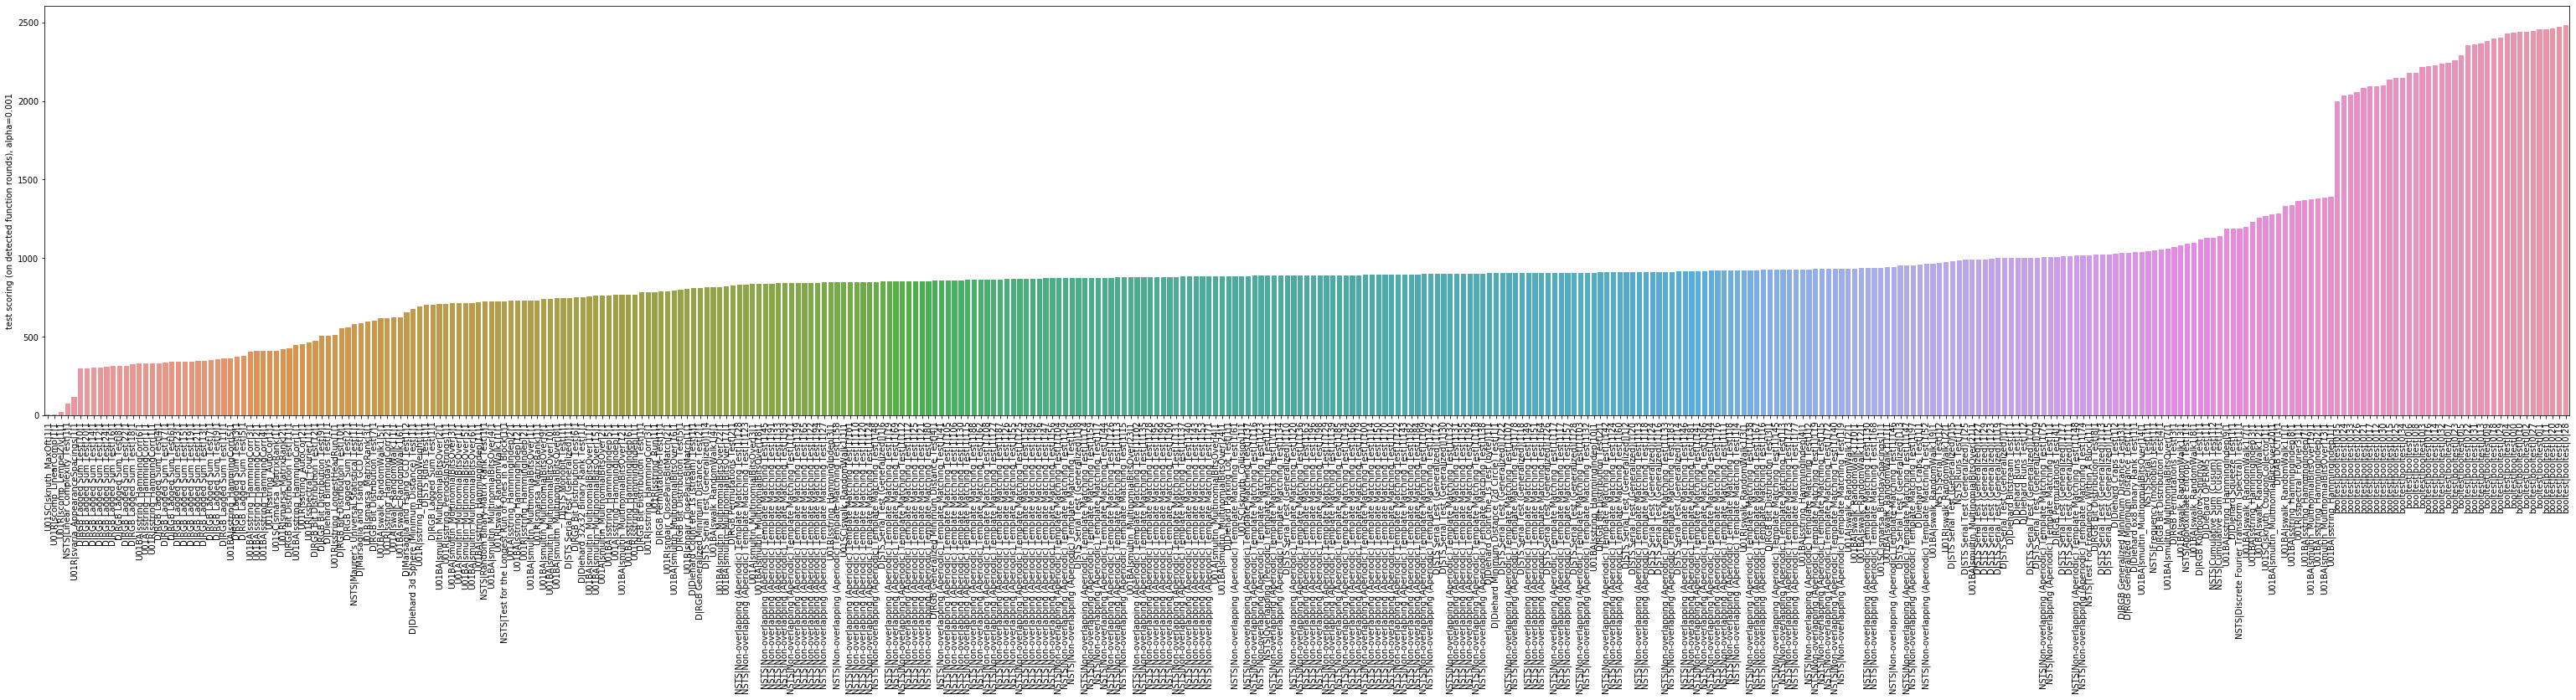

In [47]:
round_scoring(exps, subtests_srt, tf_all, alpha=1e-3, desc='', gwidth=3.0)  # tf_8gib

In [ ]:
#[x[0] for x in tests_srt]

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")
rs = np.random.RandomState(8)

# Set up the matplotlib figure
#f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
f, (ax1) = plt.subplots(1, 1, figsize=(7, 5), sharex=True)

# Generate some sequential data
x = np.array(list("ABCDEFGHIJ"))
y1 = np.arange(1, 11)
ppp = sns.barplot(x=x, y=y1, palette="rocket", ax=ax1)
ax1.axhline(0, color="k", clip_on=False)
ax1.set_ylabel("Sequential")
print(ppp)
for p in ppp.patches:
    print(p)

# # Center the data to make it diverging
# y2 = y1 - 5.5
# sns.barplot(x=x, y=y2, palette="vlag", ax=ax2)
# ax2.axhline(0, color="k", clip_on=False)
# ax2.set_ylabel("Diverging")

# # Randomly reorder the data to make it qualitative
# y3 = rs.choice(y1, len(y1), replace=False)
# sns.barplot(x=x, y=y3, palette="deep", ax=ax3)
# ax3.axhline(0, color="k", clip_on=False)
# ax3.set_ylabel("Qualitative")

# # Finalize the plot
# sns.despine(bottom=True)
# plt.setp(f.axes, yticks=[])
# plt.tight_layout(h_pad=2)

In [ ]:
2**16

In [ ]:
# T2: test sets
tests_sets_l = sorted([(k, tests_sets[k]) for k in tests_sets if tests_sets[k]>=2], reverse=True)
print(tests_sets_l[:10])

In [ ]:
# T3: matrix

In [ ]:
print(tests_matrix_2)

In [ ]:
G = nx.Graph()
G2 = Graph('G')
for t in ctests:
    G.add_node(t[0])

for i in range(len(ctests)):
    for j in range(i+1, len(ctests)):
        w = tests_matrix[i][j]
        if w < 75:
            continue
            
        print("%s - %s [%s]" % (ctests[i][0], ctests[j][0], w))
        G.add_edge(ctests[i][0], ctests[j][0], weight=w, color='green' if w<=5 else 'black', size=10 if w<=5 else 2)
        G2.edge(str(ctests[i][0]), str(ctests[j][0]), penwidth=('%s' % (w-74))) # weight=w)

#print(json.dumps([list(x) for x in nx.connected_components(G)], indent=2))

In [ ]:
# print(sys.path)
# print(os.environ['PATH'])
# print(os.getenv('PATH'))
G2.engine = 'circo'
#G2.engine = 'neato'
#G2.engine = 'fdp'
#G2.engine = 'osage'
###G2.engine = 'patchwork'
#G2.engine = 'sfdp'
#G2.engine = 'twopi'
G2.view()

In [ ]:
plt.figure(figsize=(24, 24))
#nx.draw_networkx(G, with_labels=True)
#nx.draw(G, with_labels=True)
nx.draw(G, with_labels=True, pos=nx.circular_layout(G))
#nx.draw(G, with_labels=True, pos=nx.kamada_kawai_layout(G))
#nx.draw(G, with_labels=True, pos=nx.shell_layout(G, shells))
#nx.draw(self.G, with_labels=True, pos=mylay(self.shells))
#plt.savefig("/tmp/deps.png", dpi=400)

In [ ]:
# SIDAK TEST
alpha= 0.0085 #.015  # .005
pvals=[.03, .5, .21, ] + [0.001, 0.11, 0.99,]
nvals=[.07, .02, .002009, 0.98, 0.55,   0.0001 ]
ns_ex=sidak_alpha(alpha, len(nvals))
ns_cp=sidak_alpha(min(nvals), len(nvals))
nsicp=sidak_inv(min(nvals), len(nvals))
         
print('alpha: %s' % alpha)
print('min p: %s' % min(nvals))
print('sh  t: %s, %s' % (ns_ex, min(nvals) < ns_ex))
print('shi p: %s, %s' % (nsicp, nsicp < alpha))
print('')

t1 = pvals+nvals
a1 = sidak_alpha(alpha, len(t1))
print(min(t1), a1, min(t1) < a1, len(t1), "\n")

t2 = pvals+[sidak_inv(min(nvals), len(nvals))]
a2 = sidak_alpha(alpha, len(t2))
print(min(t2), a2, min(t2) < a2, len(t2), "\n")

dexp = (len(t1)) / (len(pvals)+1.)
Y = 1-(1-min(t1))**(dexp)
t3 = pvals+[Y]
a3 = sidak_alpha(alpha, len(t3))
print(Y)
print(min(t3), a2, min(t3) < a3, len(t3), "\n")
#print(sidak_inv(0.1, 5))
#print(sidak_inv(0.01, 5))

#random.shuffle(t1)
print('='*80)
print('LEN: %s' % len(t1))
ideal = merge_pvals(t1, 999)
print('M: ', ideal) # FULL merge
#ammend(t1)
#print('M: ', merge_pvals(t1, 999)) # FULL merge
print('M: ', merge_pvals(t1, 2))
print('M: ', merge_pvals(t1, 3))
print('M: ', merge_pvals(t1, 4))
print('M: ', merge_pvals(t1, 5))
print('M: ', merge_pvals(t1, 6))
print('M: ', merge_pvals(t1, 7))
print('M: ', merge_pvals(t1, 8))
print('M: ', merge_pvals(t1, 9))
print('M: ', merge_pvals(t1, 10))

In [ ]:
res_chars = {
    "False|Anderson-Darling (A2)|Kolmogorov-Smirnov (D+)|Kolmogorov-Smirnov (D-)|Std empirical corr|Std empirical mean": 12372,
    "False|Chi-square": 49314,
    "False|Normal": 19811,
    "False|Chi-square(C)|Chi-square(H)|Chi-square(J)|Chi-square(M)|Chi-square(R)": 25980,
    "True|Chi-Square": 247182,
    "False|Collision": 10350,
    "False|Bit distance": 3489,
    "False|Chi-square|Normal": 3042,
    "False|Anderson-Darling|Kolmogorov-Smirnov (D+)|Kolmogorov-Smirnov (D-)": 2613,
    "False|Chi-square|Global longest run of 1": 2184,
    "False|Anderson-Darling|Kolmogorov-Smirnov (D+)|Kolmogorov-Smirnov (D-)|Normal|Sample variance": 3029,
    "False|Anderson-Darling (A2) (bits)|Anderson-Darling (A2) (runs)|Chi-square (runs)|Kolmogorov-Smirnov (D+) (bits)|Kolmogorov-Smirnov (D+) (runs)|Kolmogorov-Smirnov (D-) (bits)|Kolmogorov-Smirnov (D-) (runs)|Normal (bits)|Sample variance (bits)": 442,
    "False|Anderson-Darling|Chi-square": 1724,
    "True|Kolmogorov-Smirnov": 121542,
    "False|A2 (m-NP)|A2 (mNP1)|AD (NP)|AD (mNP2)|Jumps Y (mN)": 413,
    "False|A2 (m-NP)|A2 (mNP1)|AD (NP)|AD (mNP2)|AD (mNP2-S)|Jumps Y (mN)": 824,
    "False|Anderson-Darling - AD (A2)|Anderson-Darling - KS (D+)|Anderson-Darling - KS (D-)|Chi-square - AD (A2)|Chi-square - KS (D+)|Chi-square - KS (D-)|Observations sums": 858,
    "False|Anderson-Darling": 858,
    "False|Anderson-Darling|Chi-square|Kolmogorov-Smirnov (D+)|Kolmogorov-Smirnov (D-)": 858,
    "False|Unknown 0|Unknown 1|Unknown 2|Unknown 3": 1,
    "False|Unknown 0": 26520,
    "False|Unknown 0|Unknown 1": 884
}

In [ ]:
chi=0
kolm=0
ander=0
other=0
for k in res_chars:
    kl = k.lower()
    if 'chi' in kl:
        chi+=res_chars[k]
    elif 'kolm' in kl:
        kolm+=res_chars[k]
    elif 'ander' in kl:
        ander+=res_chars[k]
    else:
        other+=res_chars[k]
        
print(chi, kolm, ander,other)

In [ ]:
picked_sum = collections.defaultdict(lambda: 0)
for tt in loader.tests.values():
    
    tt_id = '|'.join(reversed(tt.short_desc()))
    for vv in tt.variants.values():
        cfv = '|'.join([str(x) for x in vv.settings.values_tuple()])

        for ss in vv.sub_tests.values():
            tfv = '|'.join([str(x) for x in ss.params.values_tuple()])
            if len(ss.stats) == 0:
                logger.debug('Null statistics for test %s:%s:%s' % (tt_id, cfv, tfv))
                continue

            picked = dump_data.pick_one_statistic(ss.stats)
            picked_sum[picked.name] += 1

print(json.dumps(picked_sum, indent=2))       

In [ ]:
def process_extended(tests, add_all=False, pick_one=False, add_passed=True):
    for tt in tests.values():
        tt_id = '|'.join(reversed(tt.short_desc()))
        tt.summarized_pvals = []
        tt.summarized_passed= []

        for vv in tt.variants.values():
            # cfs = '|'.join([str(x) for x in vv.settings.keys_tuple()])
            cfv = '|'.join([str(x) for x in vv.settings.values_tuple()])

            for ss in vv.sub_tests.values():
                # tfs = '|'.join([str(x) for x in ss.params.keys_tuple()])
                tfv = '|'.join([str(x) for x in ss.params.values_tuple()])
                if len(ss.stats) == 0:
                    logger.debug('Null statistics for test %s:%s:%s' % (tt_id, cfv, tfv))
                    continue

                if not add_all and pick_one:
                    picked = pick_one_statistic(ss.stats)
                    #self.picked_stats[picked.name] += 1
                
                desc = '{vid:%s|cfg:%s}{subid:%s|cfg:%s}' % (vv.id, cfv, ss.id, tfv)
                picked_stats = loader.pick_stats(ss.stats, add_all=add_all, pick_one=pick_one)
                picked_pvals = [x.value for x in picked_stats]
                picked_pass = [(x.passed, desc) for x in picked_stats]

                # Sidak postprocessing.
                # Compute resulting p-value from all pvalues in collected stats.
                # If pvalues are independent, result are better and we can compute one final pvalue.
                # WARNING: this strategy does not work well if resulting tree is unbalanced.
                #          It has to be perfectly symmetric.
                if not add_all and not pick_one:
                    picked_pvals = [sidak_inv(min(picked_pvals), len(picked_pvals))]
                    picked_pass = []

                tt.summarized_pvals += picked_pvals
                if add_passed:
                    tt.summarized_passed += picked_pass
                    
process_extended(loader.tests, add_all=True, add_passed=True)

In [ ]:
# Syso format dump
# {
#     "test": "TestU01 Alphabit|smultin_MultinomialBitsOver",
#     "subtest": "3|cfg:16|1|FALSE|10000000|0|32",
#     "variant": "cfg:10000000|0|32|1",
#     "data_type": "10485760|ctr|Grostl",
# }

def process_syso(tests):
    res = []
    resmap = {}
    
    for ttidx, tt in enumerate(tests.values()):
        tt_id = '|'.join(reversed(tt.short_desc()))

        for vvidx, vv in enumerate(tt.variants.values()):  # variant
            cfs = '|'.join([str(x) for x in vv.settings.keys_tuple()])
            cfv = '|'.join([str(x) for x in vv.settings.values_tuple()])
    
            tmpsubs = []
            for ssidx, ss in enumerate(vv.sub_tests.values()):  # subtest
                tfv = '|'.join([str(x) for x in ss.params.values_tuple()])
                tmpsubs.append((tfv, ss))
            
            subs_acc = []
            sorter = lambda x: x[0]
            for k, g in itertools.groupby(sorted(tmpsubs, key=sorter), sorter):
                subs_acc.append([x[1] for x in g])
            
            for skidx, gs in enumerate(subs_acc):
                ss = gs[0]
                tfs = '|'.join([str(x) for x in ss.params.keys_tuple()])
                tfv = '|'.join([str(x) for x in ss.params.values_tuple()])
                
                tsubs = []
                cobj = collections.OrderedDict([
                        ('test', tt_id),
                        ('subtest', '%s' % tfv),
                        ('subtest_type', tfs),
                        ('variant', cfv),
                        ('variant_type', cfs),
                        ('variant_id', vv.id),
                        ('exid', tt.battery.exp.id),
                        ('data_type', tt.battery.exp.name),
                        ('subs', tsubs),
                    ])
                
                for ssidx, ss in enumerate(gs):
                    cstats = [collections.OrderedDict([
                       ('name', _st.name),
                       ('value', _st.value),
                       ('pass', _st.passed),
                    ]) for _st in ss.stats]
                    
                    csub = collections.OrderedDict([
                        ('sid', ss.id),
                        ('idx', ss.idx),
                        ('pvals', ss.pvals),
                        ('stats', cstats)
                    ]) 
                    tsubs.append(csub)
                    
                res.append(cobj)
                
        #if ttidx > 1:
        #    break
    return res

res = process_syso(loader.tests)
json.dump(res, open('/tmp/syso-full-ref-ex19-20-21.json', 'w+'), indent=2)

#print(json.dumps(res, indent=2))

In [ ]:
# Syso json
# tests[test-name][experiment-name:size-meth-fnc-round]
# tests = [test-name][exp-idx] -> pvalue

tests_mult = collections.defaultdict(lambda: [None] * len(exps))
for tt in loader.tests.values():
    tt_id = '|'.join(reversed(tt.short_desc()))
    tests_mult[tt_id][rev_exp[tt.battery.exp.name]] = list(zip(tt.summarized_pvals, tt.summarized_passed))

sys_grouper = lambda x: (x.size, x.meth, x.fnc_name, x.fnc_round)
exps_sys = sorted(exps, key=lambda x: sys_grouper(x.exp_info))

all_pvals = []
tests_to_use = tests_mult
tests_sys = collections.defaultdict(lambda: collections.defaultdict(lambda: list))
for ti, tt in enumerate(tests_to_use):
    
    # Sort so the experiments that should be grouped are next to each other. Only for valid pvalues (test finished)
    cur = sorted([(eidx, pval) for eidx, pval in enumerate(tests_to_use[tt]) if pval is not None], key=lambda x: sys_grouper(exps[x[0]].exp_info))
    
    # Group by the experiments with same size-meth-fnc-round
    for k, g in itertools.groupby(cur, key=lambda x: sys_grouper(exps[x[0]].exp_info)):
        g = list(g)
        ckey = '|'.join([str(x) for x in k])
        tests_sys[tt][ckey] = [x[1] for x in g]
        for l1 in [x[1] for x in g]:
            for l2 in l1:
                all_pvals.append(l2[0])

json.dump(tests_sys, open('/tmp/syso-secmargin-pvals-ex-15.json', 'w+'), indent=2)

In [ ]:
def avg(x):
    return sum(x)/len(x)

In [ ]:
plt.hist([x for x in all_pvals if x > 0.9999], bins=25, log=True)

In [ ]:
print('='*80)
print('Test config vars:')
print(json.dumps(test_configs_var, indent=2))

print('='*80)
print('Test config types:')
lst = sorted(set(list(flat_configs_types['ALL'].keys())))
print(json.dumps(lst, indent=2))

print('='*80)
print('Test configs:')
lst = sorted(set(list(flat_configs['ALL'].keys())))
print(json.dumps(lst, indent=2))

print('='*80)
print('Flat configs:')
print(json.dumps(flat_configs, indent=2))

In [ ]:
json.dump(tests_mult, open('sysotmp2.json', 'w+'), indent=2)

In [ ]:
inp='''697852938	0.004914669785648584	3025838
697852939	0.006502269767224789	3025838
697852940	0.014632189646363258	3025838
697852941	0.016551120206713676	3025838
697852942	0.0186814796179533	3025838
697852943	0.019112680107355118	3025838
697852944	0.02417387068271637	3025838
697852945	0.02553240954875946	3025838
697852946	0.029523009434342384	3025838
697852947	0.03490941971540451	3025838
697852948	0.04425868019461632	3025838
697852949	0.04603486880660057	3025838
697852950	0.047173768281936646	3025838
697852951	0.04951927065849304	3025838
697852952	0.05146192014217377	3025838
697852953	0.053719330579042435	3025838
697852954	0.05765518918633461	3025838
697852955	0.05792544037103653	3025838
697852956	0.07670781761407852	3025838
697852957	0.0794355496764183	3025838
697852958	0.08880814909934998	3025838
697852959	0.08994050323963165	3025838
697852960	0.09938798099756241	3025838
697852961	0.1060771495103836	3025838
697852962	0.10736676305532455	3025838
697852963	0.1095411628484726	3025838
697852964	0.11443573236465454	3025838
697852965	0.11763039976358414	3025838
697852966	0.11948402225971222	3025838
697852967	0.13054220378398895	3025838
697852968	0.15809056162834167	3025838
697852969	0.1620711386203766	3025838
697852970	0.1632203459739685	3025838
697852971	0.16437481343746185	3025838
697852972	0.16437481343746185	3025838
697852973	0.1649540364742279	3025838
697852974	0.1684570610523224	3025838
697852975	0.19046929478645325	3025838
697852976	0.22242805361747742	3025838
697852977	0.22452212870121002	3025838
697852978	0.2308710366487503	3025838
697852979	0.23444108664989471	3025838
697852980	0.23515872657299042	3025838
697852981	0.2380414456129074	3025838
697852982	0.23876513540744781	3025838
697852983	0.23949004709720612	3025838
697852984	0.24167191982269287	3025838
697852985	0.24902215600013733	3025838
697852986	0.24976366758346558	3025838
697852987	0.2534887492656708	3025838
697852988	0.2633088529109955	3025838
697852989	0.26867592334747314	3025838
697852990	0.2955014705657959	3025838
697852991	0.3003603219985962	3025838
697852992	0.30361947417259216	3025838
697852993	0.314318984746933	3025838
697852994	0.3193110525608063	3025838
697852995	0.32433614134788513	3025838
697852996	0.3353331685066223	3025838
697852997	0.34217217564582825	3025838
697852998	0.34303078055381775	3025838
697852999	0.34647315740585327	3025838
697853000	0.3779962360858917	3025838
697853001	0.3806636333465576	3025838
697853002	0.38333672285079956	3025838
697853003	0.4076303541660309	3025838
697853004	0.4139912724494934	3025838
697853005	0.41672444343566895	3025838
697853006	0.42128854990005493	3025838
697853007	0.42403215169906616	3025838
697853008	0.4304480254650116	3025838
697853009	0.43136611580848694	3025838
697853010	0.4387238025665283	3025838
697853011	0.44241076707839966	3025838
697853012	0.45627880096435547	3025838
697853013	0.4581322968006134	3025838
697853014	0.4655549228191376	3025838
697853015	0.48974794149398804	3025838
697853016	0.4972037076950073	3025838
697853017	0.5823636054992676	3025838
697853018	0.5887377262115479	3025838
697853019	0.6014142036437988	3025838
697853020	0.6483394503593445	3025838
697853021	0.658685564994812	3025838
697853022	0.6806889176368713	3025838
697853023	0.7109201550483704	3025838
697853024	0.7366911768913269	3025838
697853025	0.7691289782524109	3025838
697853026	0.7803466320037842	3025838
697853027	0.7972322106361389	3025838
697853028	0.8219696283340454	3025838
697853029	0.8237902522087097	3025838
697853030	0.8491302728652954	3025838
697853031	0.8598040342330933	3025838
697853032	0.8728957772254944	3025838
697853033	0.8837463855743408	3025838
697853034	0.9249604940414429	3025838
697853035	0.9500006437301636	3025838
697853036	0.9639958143234253	3025838
697853037	0.9678769111633301	3025838'''


inp='''697853338	0.000011250000170548446	3025842
697853339	0.00350211001932621	3025842
697853340	0.009129649959504604	3025842
697853341	0.010111579671502113	3025842
697853342	0.010273230262100697	3025842
697853343	0.025871990248560905	3025842
697853344	0.028826050460338593	3025842
697853345	0.030500030145049095	3025842
697853346	0.04602126032114029	3025842
697853347	0.04904283955693245	3025842
697853348	0.05152222886681557	3025842
697853349	0.056505098938941956	3025842
697853350	0.0834764614701271	3025842
697853351	0.085155189037323	3025842
697853352	0.08632293343544006	3025842
697853353	0.08964061737060547	3025842
697853354	0.09910307079553604	3025842
697853355	0.10003849864006042	3025842
697853356	0.10338187962770462	3025842
697853357	0.11141431331634521	3025842
697853358	0.11185982823371887	3025842
697853359	0.11848258227109909	3025842
697853360	0.12144789844751358	3025842
697853361	0.17934998869895935	3025842
697853362	0.18065841495990753	3025842
697853363	0.19085368514060974	3025842
697853364	0.19850070774555206	3025842
697853365	0.23529300093650818	3025842
697853366	0.24311693012714386	3025842
697853367	0.24556083977222443	3025842
697853368	0.25612300634384155	3025842
697853369	0.2598739266395569	3025842
697853370	0.26305291056632996	3025842
697853371	0.27871841192245483	3025842
697853372	0.2806601822376251	3025842
697853373	0.31267422437667847	3025842
697853374	0.3130578398704529	3025842
697853375	0.3209002912044525	3025842
697853376	0.3295722007751465	3025842
697853377	0.34895023703575134	3025842
697853378	0.34903621673583984	3025842
697853379	0.36707979440689087	3025842
697853380	0.3728322386741638	3025842
697853381	0.3912302255630493	3025842
697853382	0.3987952470779419	3025842
697853383	0.41622036695480347	3025842
697853384	0.41763949394226074	3025842
697853385	0.431035578250885	3025842
697853386	0.4445094168186188	3025842
697853387	0.4635542035102844	3025842
697853388	0.4677604138851166	3025842
697853389	0.47136151790618896	3025842
697853390	0.47390589118003845	3025842
697853391	0.4776434898376465	3025842
697853392	0.47958147525787354	3025842
697853393	0.4808431565761566	3025842
697853394	0.48542582988739014	3025842
697853395	0.5012537837028503	3025842
697853396	0.5057639479637146	3025842
697853397	0.5154284834861755	3025842
697853398	0.5185425281524658	3025842
697853399	0.5372365713119507	3025842
697853400	0.5520502328872681	3025842
697853401	0.5642455220222473	3025842
697853402	0.5806460380554199	3025842
697853403	0.5911000967025757	3025842
697853404	0.6054104566574097	3025842
697853405	0.6066920757293701	3025842
697853406	0.6142104268074036	3025842
697853407	0.6163209676742554	3025842
697853408	0.6364975571632385	3025842
697853409	0.6469718813896179	3025842
697853410	0.6490170955657959	3025842
697853411	0.6604179739952087	3025842
697853412	0.6644731163978577	3025842
697853413	0.7009350061416626	3025842
697853414	0.7076488733291626	3025842
697853415	0.7148332595825195	3025842
697853416	0.7203283309936523	3025842
697853417	0.7401187419891357	3025842
697853418	0.752748966217041	3025842
697853419	0.7548877596855164	3025842
697853420	0.760158360004425	3025842
697853421	0.7782148718833923	3025842
697853422	0.7878789901733398	3025842
697853423	0.802317202091217	3025842
697853424	0.8033522367477417	3025842
697853425	0.8043506741523743	3025842
697853426	0.8281975984573364	3025842
697853427	0.8508448004722595	3025842
697853428	0.8533149361610413	3025842
697853429	0.8728923201560974	3025842
697853430	0.8927019834518433	3025842
697853431	0.9007689356803894	3025842
697853432	0.9044573903083801	3025842
697853433	0.913966178894043	3025842
697853434	0.9309571981430054	3025842
697853435	0.9310958981513977	3025842
697853436	0.9456146359443665	3025842
697853437	0.989915668964386	3025842'''

from scipy import stats
_pvals=([float(x.split('\t')[1]) for x in inp.split('\n')])
print(len(_pvals))

_pvals2 = [random.random() for _ in range(100)]
print(stats.kstest(_pvals, 'uniform', mode='asymp'))
print(stats.kstest([0.5, 0.5], 'uniform'))

In [ ]:
_pvals=[ 
        0.10647586733102798,
        0.16674716770648956,
        0.19867828488349915,
        0.20402072370052338,
        0.2072029411792755,
        0.30274155735969543,
        0.3070487082004547,
        0.3498513996601105,
        0.3598391115665436,
        0.3720359206199646,
        0.4307703375816345,
        0.5102576017379761,
        0.5586630702018738,
        0.5801839828491211,
        0.584112823009491,
        0.691771924495697,
        0.6956953406333923,
        0.7069452404975891,
        0.7123063206672668,
        0.7145896553993225,
        0.7438201904296875,
        0.9486949443817139,
        0.9836832284927368,
        0.9858270287513733
      ]
print(stats.kstest(_pvals, 'uniform'))

In [ ]:
js = json.load(open('passthenfail_pvals_subid'))

In [ ]:
def klinec(pvals):
    nls = len(pvals)
    spvals = sorted(pvals)
    exdif = 1./(nls-1)
    difs = []
    
    for i in range(1, len(pvals)):
        cdif = spvals[i] - spvals[i-1]
        difs.append(cdif)# - exdif)
    
    _av = np.average(difs)
    std = np.std(difs)
    print('Avg %s, std %s, ex: %s, len: %s' % (_av, std, exdif, nls))
    
    fig, ax = plt.subplots(1, 1)
    ax.hist(difs, log=False)
    #ax.hist(pvals)
    

In [ ]:
from scipy.stats import chi

_pvals2 = [random.random() for _ in range(1000)] + [0.9]*2
#_pvals2 = np.random.normal(0, 1, 1000)
#_pvals2 = chi.rvs(12, size=1000)
print(stats.kstest(_pvals2, 'uniform'))
print(klinec(_pvals2))

In [ ]:
def pick_km_statistic2(stats):
    if len(stats) == 0:
        return None
    for st in ['kolm']:
        for cur in stats:
            name = cur.name.lower()
            if name.startswith(st):
                return cur
    return stats[0]

mt6 = []
for ix, ex in enumerate(js):
    ex['pvals'] = []
    ex['stats'] = []
    ex['allstats'] = []
    ex['stats_names'] = []
    ex['my_ks'] = []
    
    for sid in ex['subid']:
        sid = int(sid)
        stest = loader.sids[sid]
        st = pick_km_statistic2(stest.stats)
        ex['pvals'].append(stest.pvals)
        ex['stats'].append(st.value if st else None)
        ex['stats_names'].append(st.name if st else None)
        ex['allstats'].append([(x.name, x.value, x.passed) for x in stest.stats])
        ex['my_ks'].append(stats.kstest(stest.pvals, 'uniform') if stest.pvals else None)
        if len(stest.pvals)>=10:
            _av = np.average(stest.pvals)
            if _av > 0.59:
                mt6.append((sid, _av, len(stest.pvals), stest.pvals))

for x in mt6:
    print(x)
#json.dump(js, open('syso-susp-pvals.json', 'w+'), indent=2)
    

In [ ]:
json.dump(js, open('syso-susp-pvals.json', 'w+'), indent=2)

In [ ]:
from scipy.stats import uniform
rv = uniform()

In [ ]:
x = np.linspace(uniform.ppf(0.01),uniform.ppf(0.99), 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, uniform.pdf(x), 'r-', lw=5, alpha=0.6, label='uniform pdf')

In [111]:
colors = sns.cubehelix_palette(8, start=.5, rot=-.75)

In [112]:
colors[2]

[0.5109365778646006, 0.7367198696575319, 0.5730408794126332]

In [113]:
colors[4]

[0.2884627663592704, 0.5163814459748142, 0.5434217716422115]